# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## 0. Описание проекта

### 0.1. Задача проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### 0.2. Инструкция по выполнению проекта

- Чтобы усилить исследование, не ограничиваться градиентным бустингом. 
- Попробовать более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
- Поэкспериментировать и сравнить характеристики моделей: время обучения, время предсказания, точность результата.

### 0.3. План выполнения проекта

- Загрузить данные, путь к файлу: /datasets/autos.csv.
- Изучить данные. Заполнить пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

### 0.4. Условия выполнения проекта

- Значение метрики RMSE должно быть меньше 2500.

### 0.5. Описание данных

- Данные находятся в файле /datasets/autos.csv. Скачать датасет. 

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## 1. Загрузка и общая информация

In [2]:
# Установим необходимые библиотеки

!pip -q install phik
!pip -q install lightgbm
!pip -q install shap
!pip -q install category_encoders
!pip -q install inflection
!pip -q install catboost
!pip -q install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [74]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import inflection
import shap
import os
import requests

pd.set_option('display.float_format', '{:.2f}'.format)

In [6]:
# Определим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

### 1.1. Чтение данных

In [8]:
# Загрузим файлы

base_url = "https://huggingface.co/datasets/onejetpilot/autos/resolve/main/"

files = [
    ("autos.csv", "autos.csv")
]

for filename, local_path in files:
    if not os.path.exists(local_path):
        print(f"Файл {filename} не найден — начинаю скачивание...")

        file_url = base_url + filename
        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(local_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Файл успешно скачан: {local_path}")
        else:
            print(f"Ошибка при скачивании {filename}: {response.status_code}")
    else:
        print(f"Файл {filename} уже есть локально — загрузка пропущена")


cars = pd.read_csv("autos.csv", parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

print("Все файлы успешно загружены в DataFrame")

Файл autos.csv не найден — начинаю скачивание...
Файл успешно скачан: autos.csv
Все файлы успешно загружены в DataFrame


In [9]:
# Проверим размер получившегося датасета

cars.shape

(354369, 16)

In [10]:
# Посмотрим на датасет

cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [11]:
# Приведем названия столбцов к snake_case

cars.columns = [inflection.underscore(col) for col in cars.columns]

### 1.2. Изучение общей информации о датасете

In [12]:
def overview_data(data):
    """
    Выводит информацию о DataFrame - типы данных, 
    статистику, количество пропусков и дубликатов

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, для которой требуется провести обзор

    Возвращает
    ----------
    None
        Функция выводит информацию
    """
    
    
    d = '-' * 50
    
    print(d)
    print('Инфо')
    print(d)
    print(data.info())
    print('\n')
    
    print(d)
    print('Статистика')
    print(d)
    print(data.describe)
    print('\n')
    
    print(d)
    print('Пропуски')
    print(d)
    print(data.isna().sum())
    print('\n')
    
    print(d)
    print('Дубликаты')
    print(d)
    print(data.duplicated().sum())
    print('\n')

In [13]:
# Выведем общую информацию о датасете cars
overview_data(cars)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null 

### Вывод

- много пропусков в колонках vehicle_type, gearbox, model, fuel_type, repaired - возможно получится запалнить данные пользуясь другими колонками
- 4 дубликата - удалим
- в столбцах date_crawled и last_seen даты указаны со временем - время думаю нам точно не понадобится, его можно удалить.

## 2. Анализ данных

In [14]:
def num_diag(data, x, xlabel, ylabel, hue=None):
    """
    Визуализирует распределение числового признака с помощью гистограммы и boxplot

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая признак
    
    x : str
        Название числового признака, по которому строятся графики.

    xlabel : str
        Подпись оси X для графиков

    ylabel : str
        Подпись оси Y для графиков.=

    hue : str, optional
        Название категориального признака для разделения данных по цветам на гистограмме

    Возвращает
    ----------
    None
        Функция строит графики
    """
    
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat='density',
        bins=20,
        common_norm=False)
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1])
    axes[1].set_title(f'Гистограмма размаха по {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

In [15]:
def cat_diag(data, x, xlabel, hue=None, threshold=0.015):
    """
    Строит диаграммы распределения для категориального признака: 
    countplot с группировкой и круговую диаграмму

    Малые категории по частоте объединяются в категорию "Другие"

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с данными, содержащая категориальный признак

    x : str
        Название категориального признака, по которому строятся графики

    xlabel : str
        Подпись оси X на countplot

    hue : str, optional
        Название категориального признака для группировки по цветам на countplot

    threshold : float, optional
        Порог частоты (от 0 до 1), ниже которого категории объединяются в "Другие" 
        По умолчанию 0.015 (1.5%)

    Возвращает
    ----------
    None
        Функция строит графики
    """
        
        
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts<threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)
    
    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index)
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)
    
    pie_data = data_modified[x].value_counts(normalize=True)
    
    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False)
    axes[1].set_title('Распределение долей')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

In [16]:
def date_diag(data, x, hue=None, figsize=(16, 6)):
    """
    Строит временную диаграмму (countplot) по дате.

    Преобразует datetime-признак в даты без времени и отображает 
    количество записей по каждой дате. Если нужно, можно применить 
    цветовую группировку по hue

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая временной признак

    x : str
        Название столбца с типом datetime

    hue : str, optional
        Название категориального признака для группировки по цветам

    figsize : tuple, optional
        Размер графика в формате (ширина, высота), по умолчанию (16, 6)

    Возвращает
    ----------
    None
        Функция строит график
    """
    
    
    data_modified = data.copy()
    data_modified['date'] = data_modified[x].dt.date
    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=data_modified,
        x='date',
        hue=hue,
        order=sorted(data_modified['date'].unique()))
        
    plt.title(f'Диаграмма по {x}')
    plt.xlabel('Дата')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [17]:
def all_diag(data, column_type='numeric', hue=None):
    """
    Автоматически визуализирует признаки заданного типа: числовые, категориальные или временные.

    В зависимости от типа признаков вызывает соответствующие функции визуализации 
    (num_diag, cat_diag, date_diag) для каждого подходящего столбца в DataFrame.

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных для анализа

    column_type : str, optional
        Тип признаков для визуализации. Возможные значения:
        - 'numeric' — числовые признаки
        - 'categorical' — категориальные признаки
        - 'date' или 'datetime' — временные признаки

    hue : str, optional
        Название столбца для цветовой группировки, если нужно

    Возвращает
    ----------
    None
         Функция строит график
    """     
    
    
    if column_type == 'numeric':
        columns = data.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = data.select_dtypes(include=['object', 'category']).columns
    elif column_type in ('date', 'datetime'):
        columns = data.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
        
    for col in columns:
        if column_type == 'numeric':
            print(f'Визуализация числового признака: {col}')
            num_diag(data, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f'Визуализация категориального признака {col}')
            cat_diag(data, x=col, xlabel=col, hue=hue)
        elif column_type == 'date':
            print(f'Визуализация верменного признака: {col}')
            date_diag(data, x=col, hue=hue)

### 2.1. Анализ числовых признаков

Визуализация числового признака: price


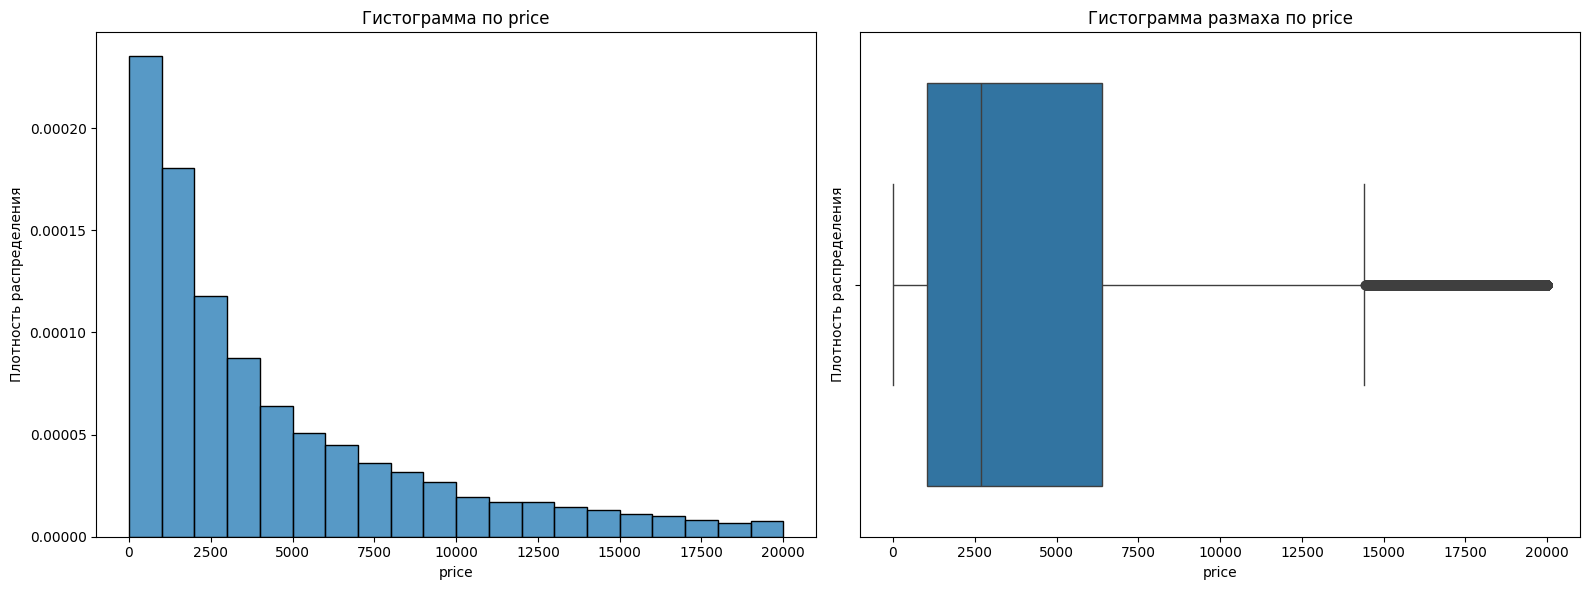

Визуализация числового признака: registration_year


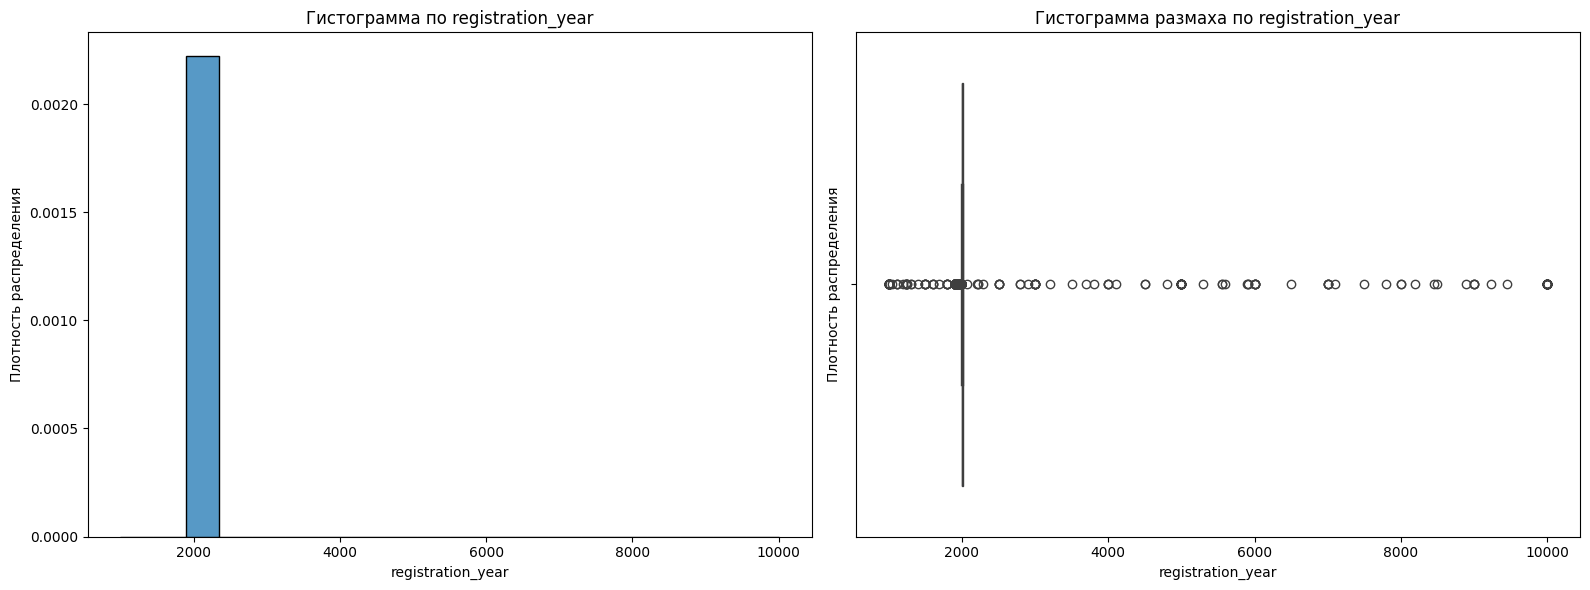

Визуализация числового признака: power


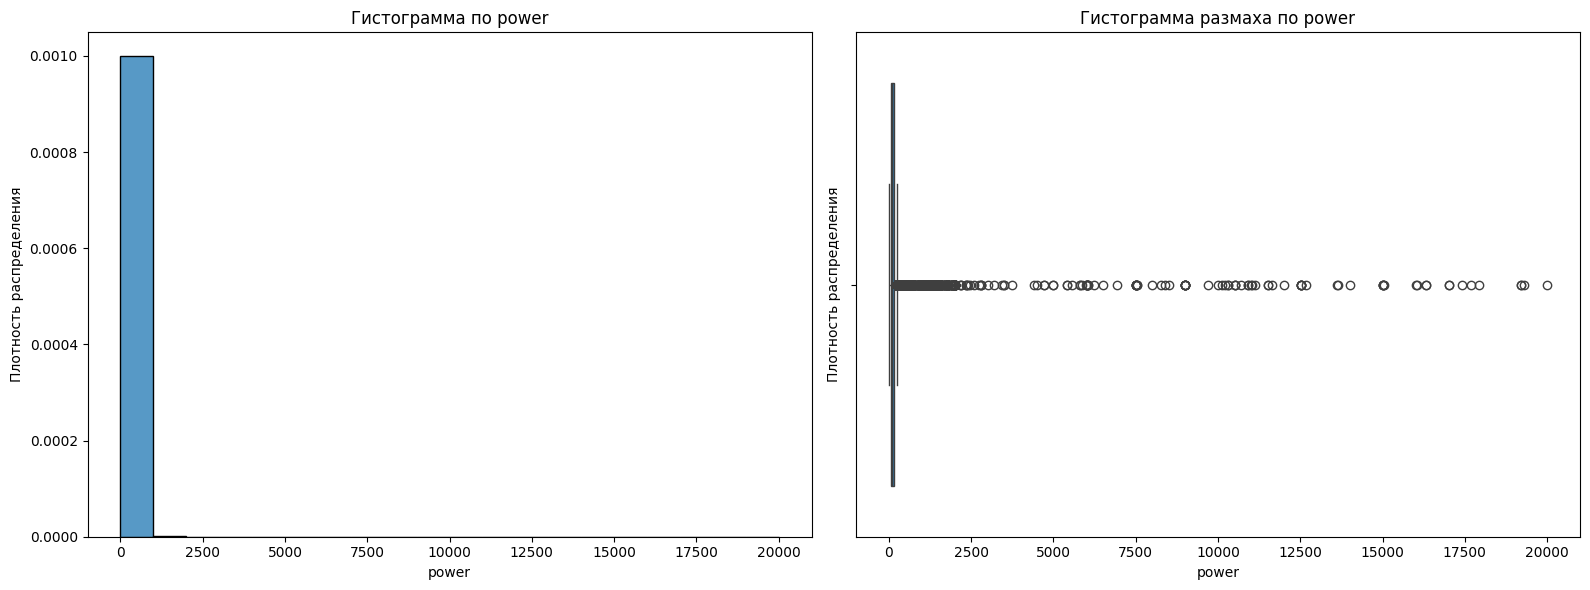

Визуализация числового признака: kilometer


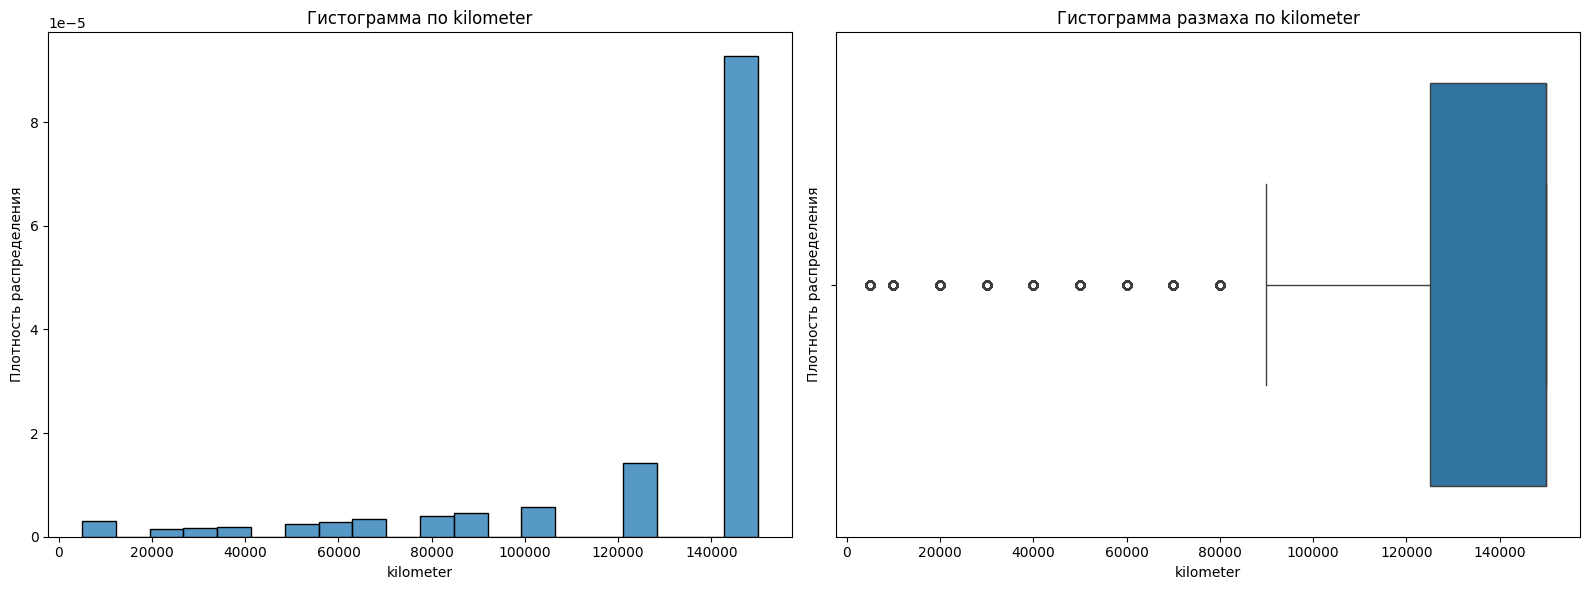

Визуализация числового признака: registration_month


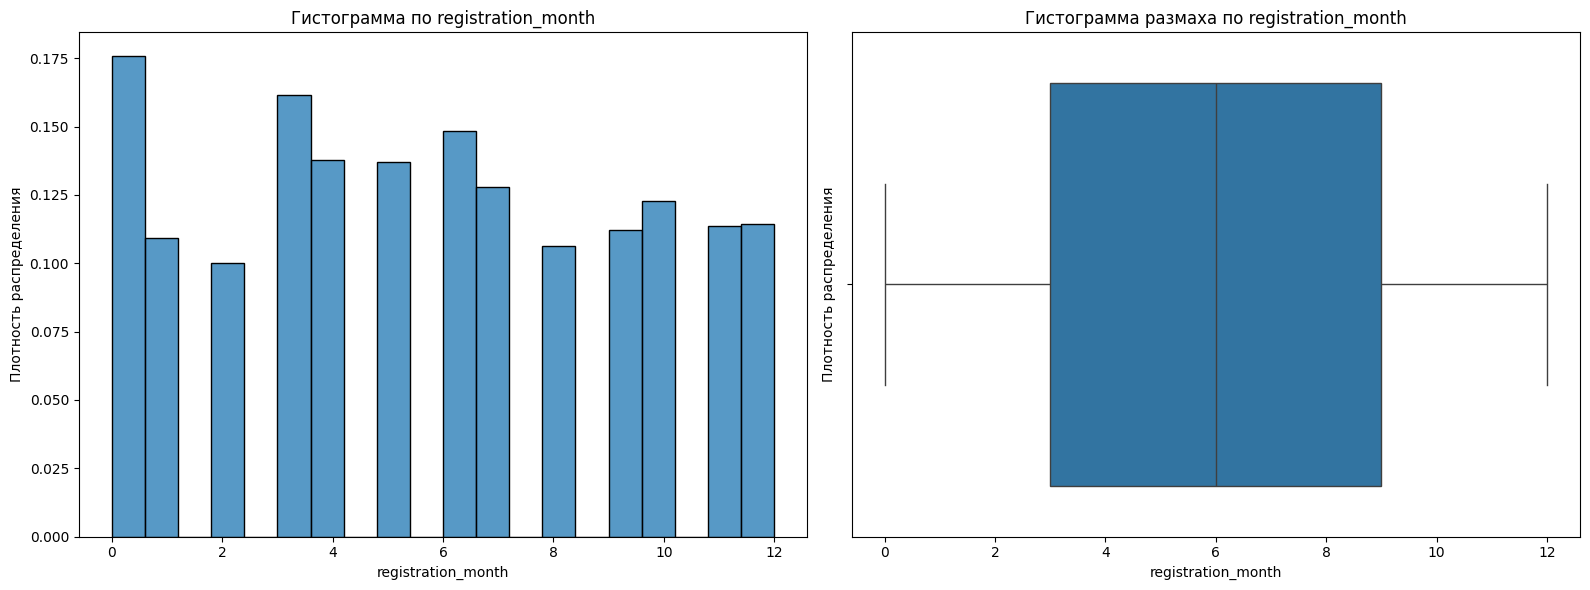

Визуализация числового признака: number_of_pictures


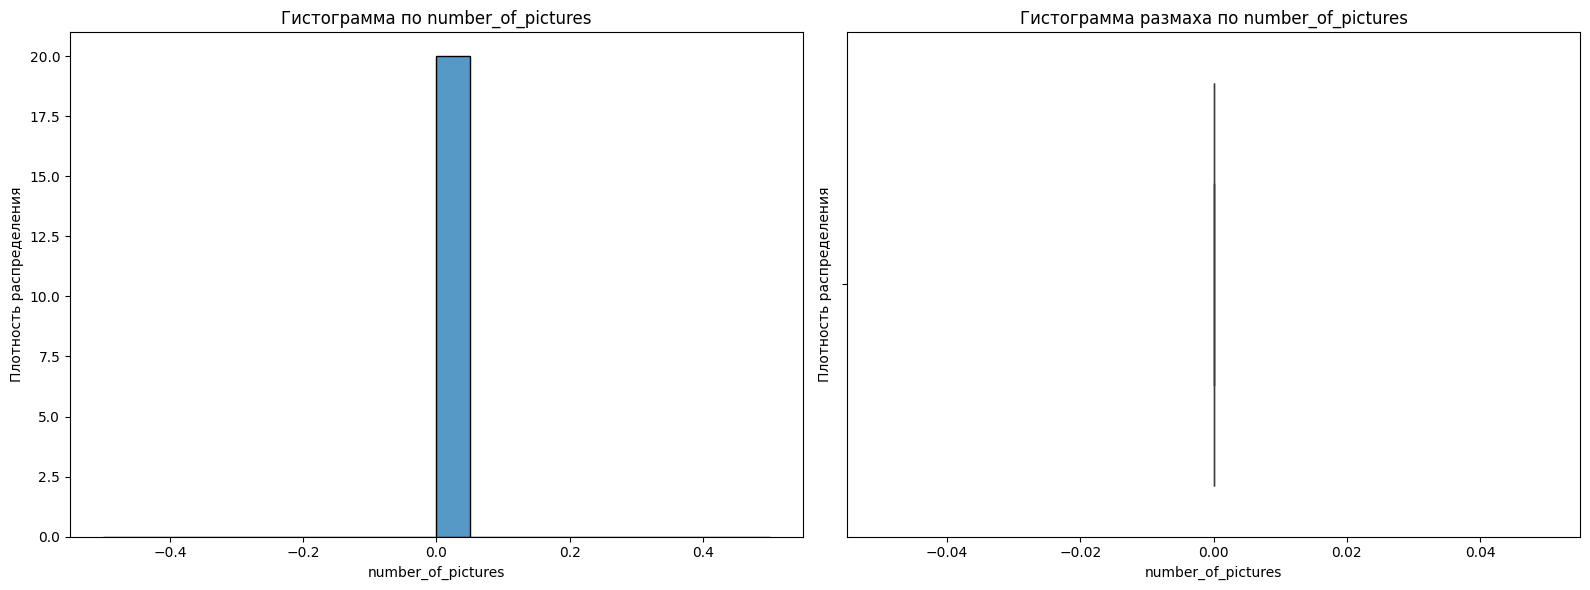

Визуализация числового признака: postal_code


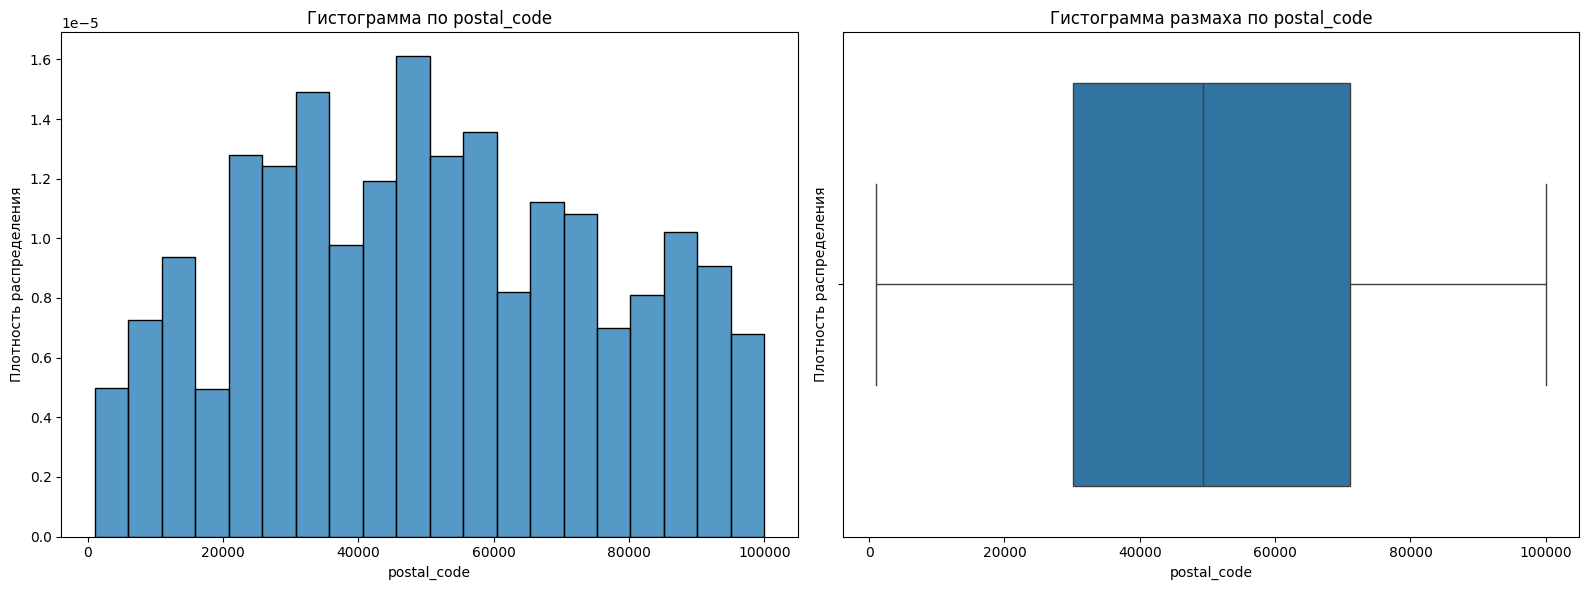

In [18]:
# Визуализируем числовые признаки

all_diag(cars, column_type='numeric', hue=None)

По графикам можно увидеть что у нас много ошибок в данных, сначала разберемся с ними

In [19]:
# Посчитаем количество машин с 0й ценой

(cars['price']==0).sum()

10772

In [20]:
# Выведем 5 самых дорогих машин

cars.nlargest(5, 'price')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1515,2016-03-09 10:18:36,20000,sedan,2010,auto,239,a6,150000,5,gasoline,audi,no,2016-03-07,0,56567,2016-03-30 19:17:04
1586,2016-04-03 21:41:49,20000,sedan,2014,auto,184,leon,40000,4,gasoline,seat,no,2016-04-03,0,30655,2016-04-05 22:18:39
2128,2016-03-30 09:50:58,20000,sedan,2014,manual,135,ceed,30000,3,petrol,kia,no,2016-03-30,0,39307,2016-03-30 10:44:12
3728,2016-03-28 14:25:18,20000,sedan,2011,auto,265,c_klasse,50000,11,gasoline,mercedes_benz,no,2016-03-28,0,60311,2016-03-28 15:07:23
6286,2016-04-01 11:55:42,20000,sedan,2009,auto,272,e_klasse,150000,9,gasoline,mercedes_benz,no,2016-04-01,0,41749,2016-04-07 08:17:24


price - есть ошибки в цене, около 10 тыс автомобилей имеют 0ю цену. Т.к. это наш целевой признак то мы их удалим. Как можно понять по ценам, у нас в датасете представлены автомобили до 20 тыс. поэтому каких то особенных автомобилей в топе по цене нет - это премиальные марки авто или бюджетные марки с маленьким пробегом и хорошей комплектацией судя по мощности.

In [21]:
# Посчитаем количество машин с неправильным годом регистрации

((cars['registration_year'] > 2025) | (cars['registration_year'] < 1960)).sum()

527

registration_year - тут явно есть ошибки в годах регистрации автомобиля, всего таких значений 527. Все что выше 2025 и ниже 1960 удалим.

In [22]:
# Отфильтруем по мощности авто

cars[cars['power']>500].head(50)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14,0,40721,2016-03-14 15:54:34
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31,0,70327,2016-04-06 14:17:51
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02,0,65830,2016-04-06 11:46:49
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,0,21509,2016-04-04 09:15:26


In [23]:
# Посчитаем количество машин с неправильным годом регистрации

(cars['power']>500).sum()

459

In [24]:
# Посчитаем количество авто с нулевой мощностью

(cars['power']==0).sum()

40225

power - есть ошибки, если отобрать авто от 500 л.с. то мы увидим много малолитражек по низкой цене с нереальной мощностью, однако втречаются премиальные марки авто типа порше которые вполне могут иметь такую мощность. Думаю в нашем ценовом диапазоне все что больше 500 л.с. мы можем удалить т.к. таких автомобилей всего 459. Также у нас очень много авто с 0й мощностью.

kilometer, registration_month, number_of_pictures, postal_code  - в этих данних каких либо аномалий по-моему нет

In [25]:
# Отфильруем датасет от ошибочных данных

clean_cars = cars[
    (cars['price'] > 0) &
    (cars['registration_year'] < 2016) &
    (cars['registration_year'] > 1960) &
    (cars['power'] < 500) &
    (cars['power'] > 0) &
    (cars['registration_year'] <= cars['date_created'].dt.year)
]

In [26]:
def cat_price(p):
    """
    Разбивает цену на категории: 'cheap', 'mid', 'expensive'.

    Параметры
    ----------
    p : float or int
        Значение цены.

    Возвращает
    ----------
    str
        Категория цены:
        - 'cheap' если p <= 1 000
        - 'mid' если 1 000 < p <= 15 000
        - 'expensive' если 15 000 < p <= 30 000
    """

    if p <= 1000:
        return 'cheap'
    elif p <= 15000:
        return 'mid'
    elif p <= 30000:
        return 'expensive'

In [27]:
# Создадим категории цен

clean_cars['price_cat'] = clean_cars['price'].apply(cat_price)

/tmp/ipykernel_169662/2964090442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cars['price_cat'] = clean_cars['price'].apply(cat_price)


In [28]:
# Проверим размер получившегося датасета

print(clean_cars.shape)
print(cars.shape)

(289890, 17)
(354369, 16)


Визуализация числового признака: price


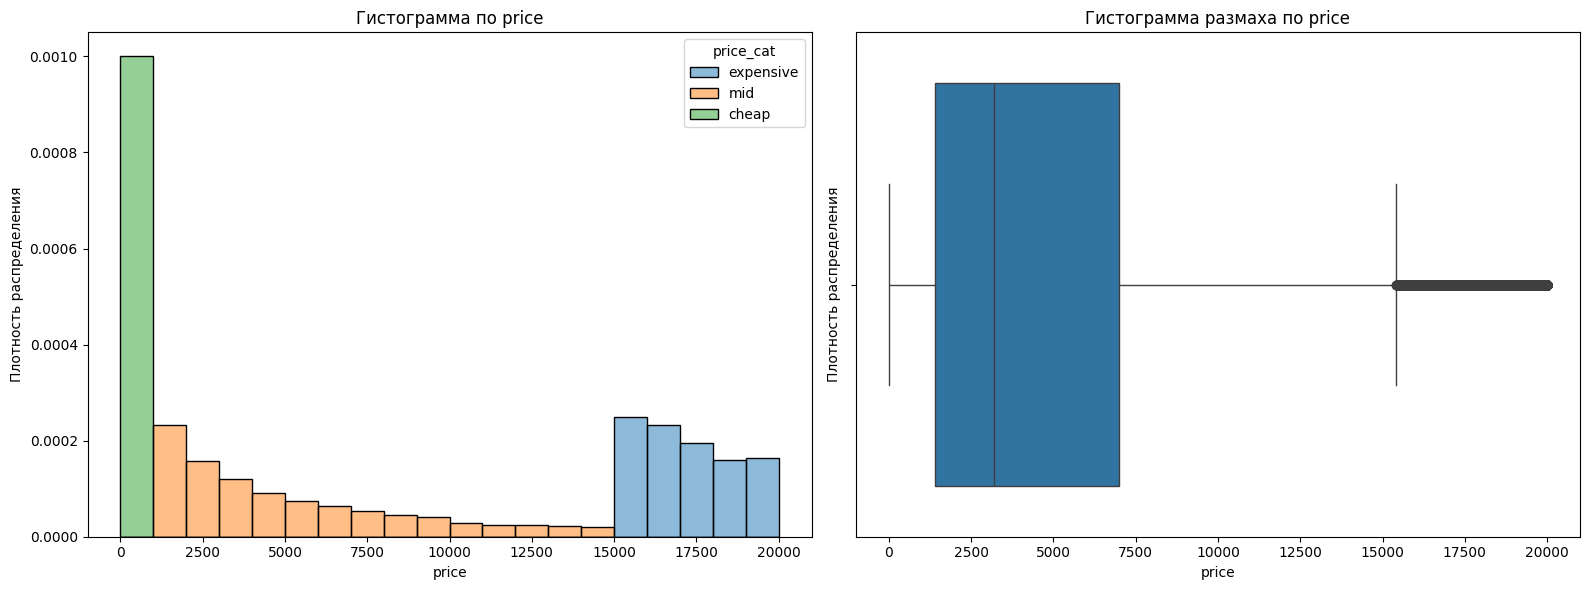

Визуализация числового признака: registration_year


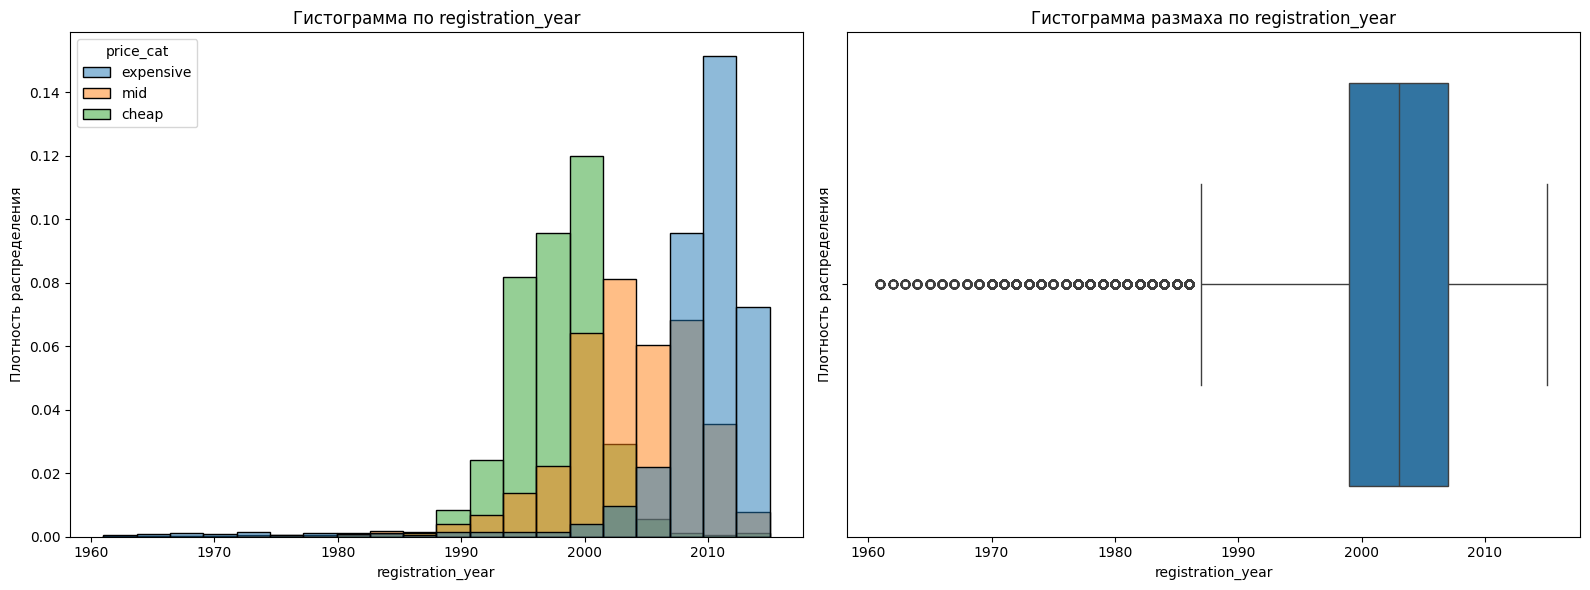

Визуализация числового признака: power


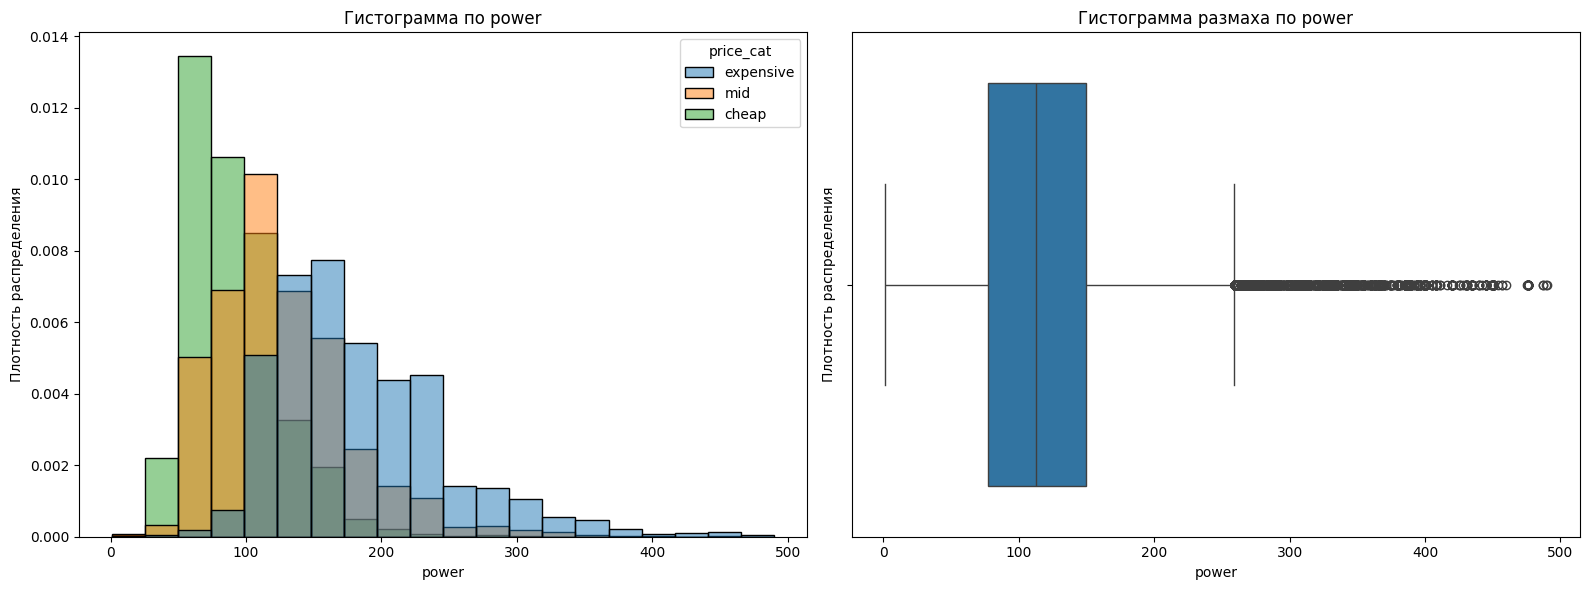

Визуализация числового признака: kilometer


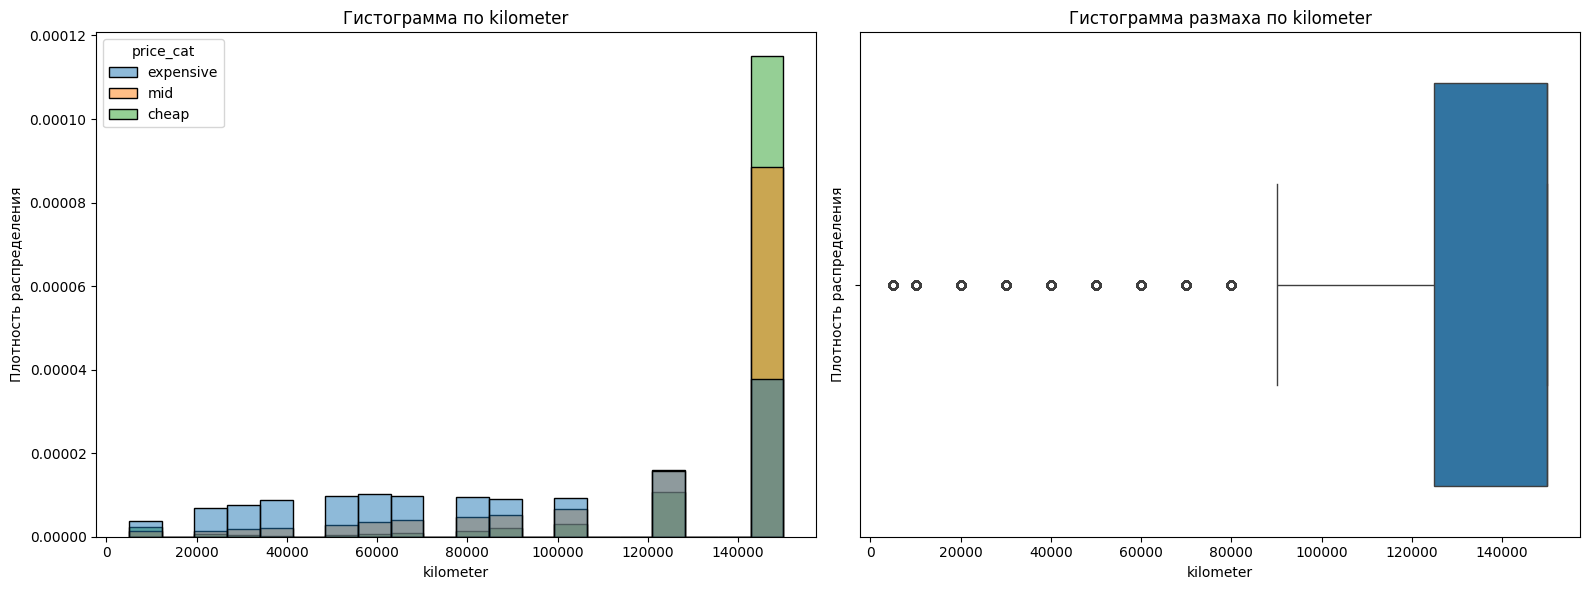

Визуализация числового признака: registration_month


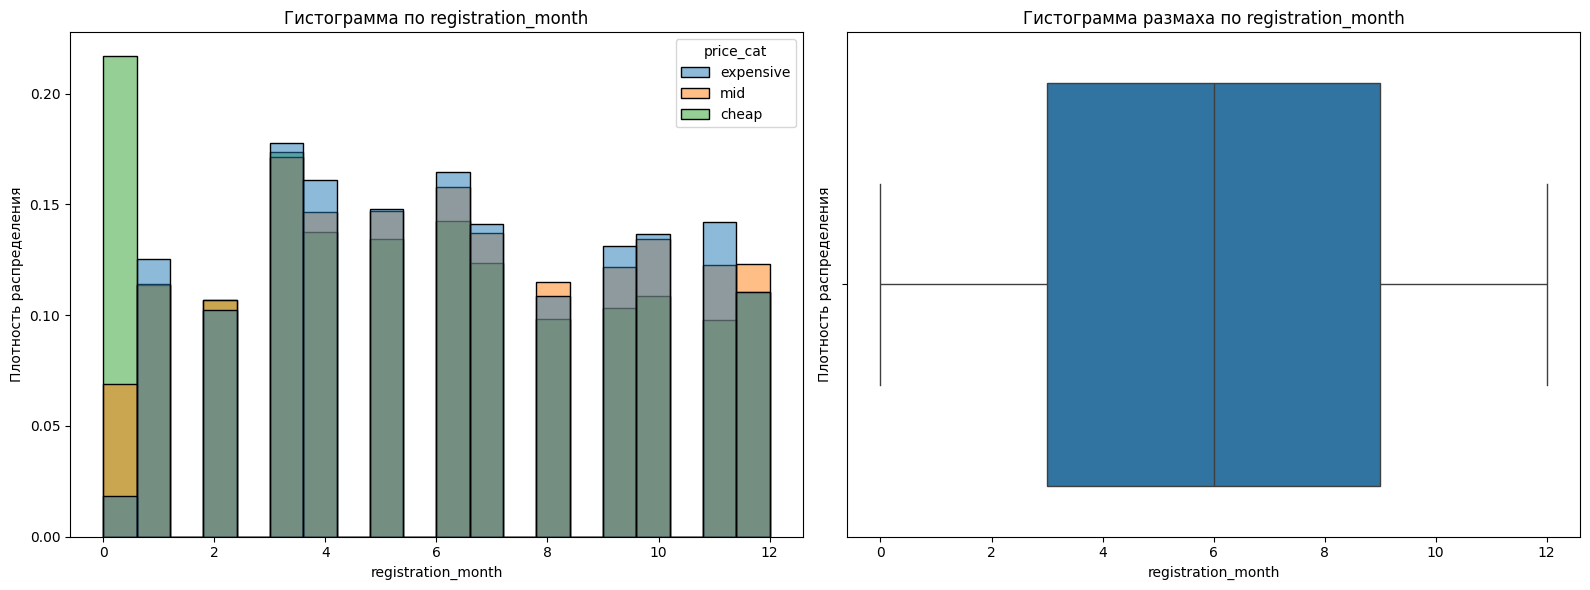

Визуализация числового признака: number_of_pictures


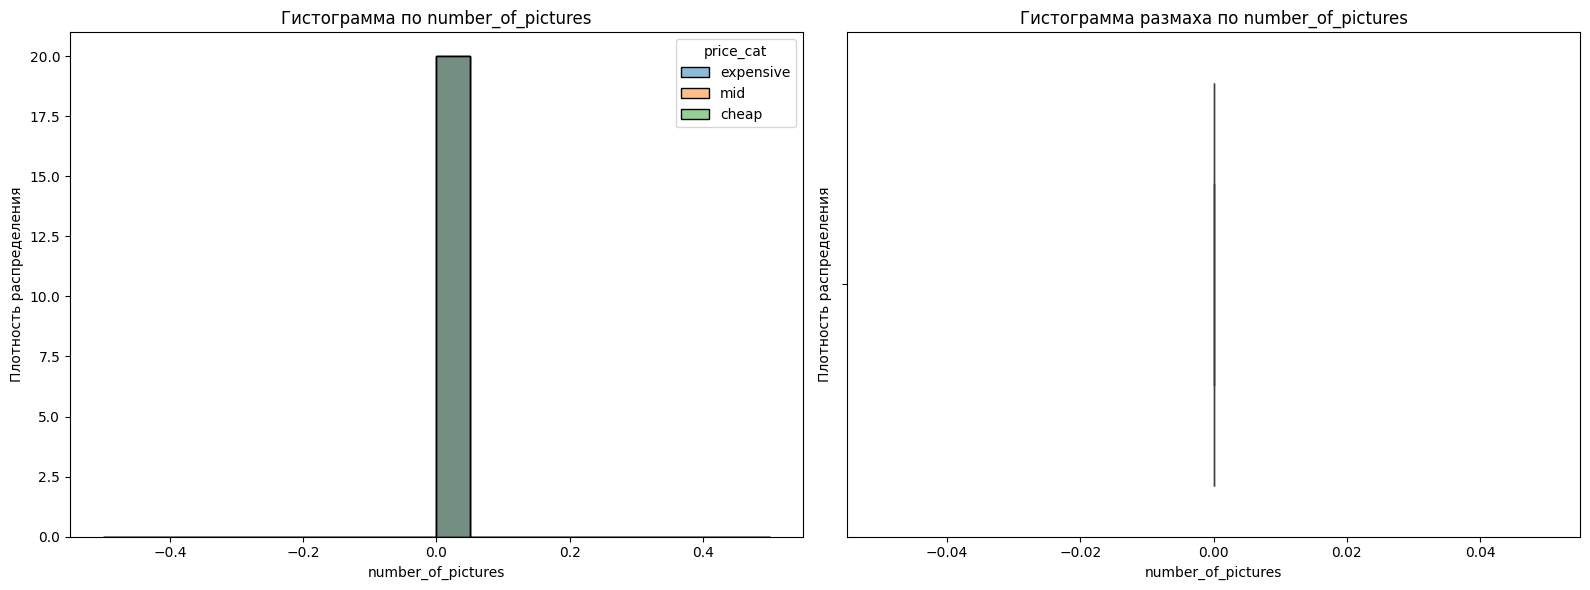

Визуализация числового признака: postal_code


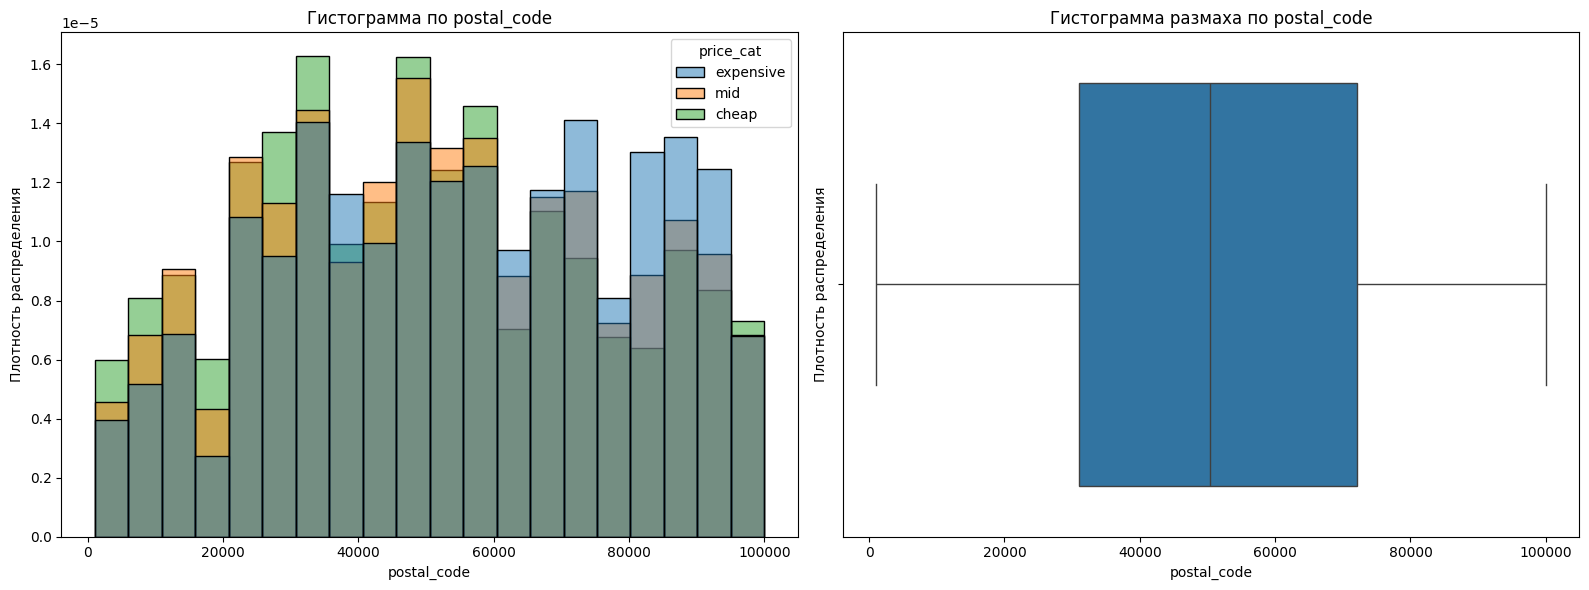

In [29]:
# Построим графики числовых признаков на очишенном датасете

all_diag(clean_cars, column_type='numeric', hue='price_cat')

Так стало более наглядно, посмотрим на наши числовые признаки.

price - цена на авто выглядит адекватно, оснавная масса автомобилей продается в диапазоне между 1500 и 7000. Есть как совсем дешевые авто так и авто по 20000.

registration_year - после фильтрации год регистрации выглядит более наглядно, можно увидеть что автомобили восновном регистрировались между 1998 и 2008 годом. Также можно увидеть, что год регистрации сильно влияет на цену - дорогие авто как правило более новые, а дешевые более старые. Думаю это важный принак.

power - мощность также стала более адекватной, основная часть машин имеет мощность примерно от 80 до 150 л.с. По мощности примерно также, чем мощнее авто тем оно дороже. Также думаю важный признак для предсказания.

kilometer - пробег также выглядит адекватным - между 130 тыс.км и 150 тыс.км. Дорогих авто больше с маленьким пробегов, а дешевых наоборот с большим. Также важный признак.

registration_month - в начале года региструется большая часть дешевых авто, хотя это может быть просто неверные данные. Думаю этот признак никак не может влиять на цену авто и его можно удалить.

number_of_pictures - количество фото, признак полностью заполнен нулями - удаляем его.

postal_code - по этому признаку сложно что либо понять, однако он связан с регионом где находится владелец. Место продажи может влиять на цену авто, пока оставим этот признак. Видно, что из региона с кодом начинающимся и 7 и больше - больше продаются дорогие авто. Возможно это более премиальный район где у людей более дорогие авто. 

### 2.2 Анализ категориальных признаков

Визуализация категориального признака vehicle_type


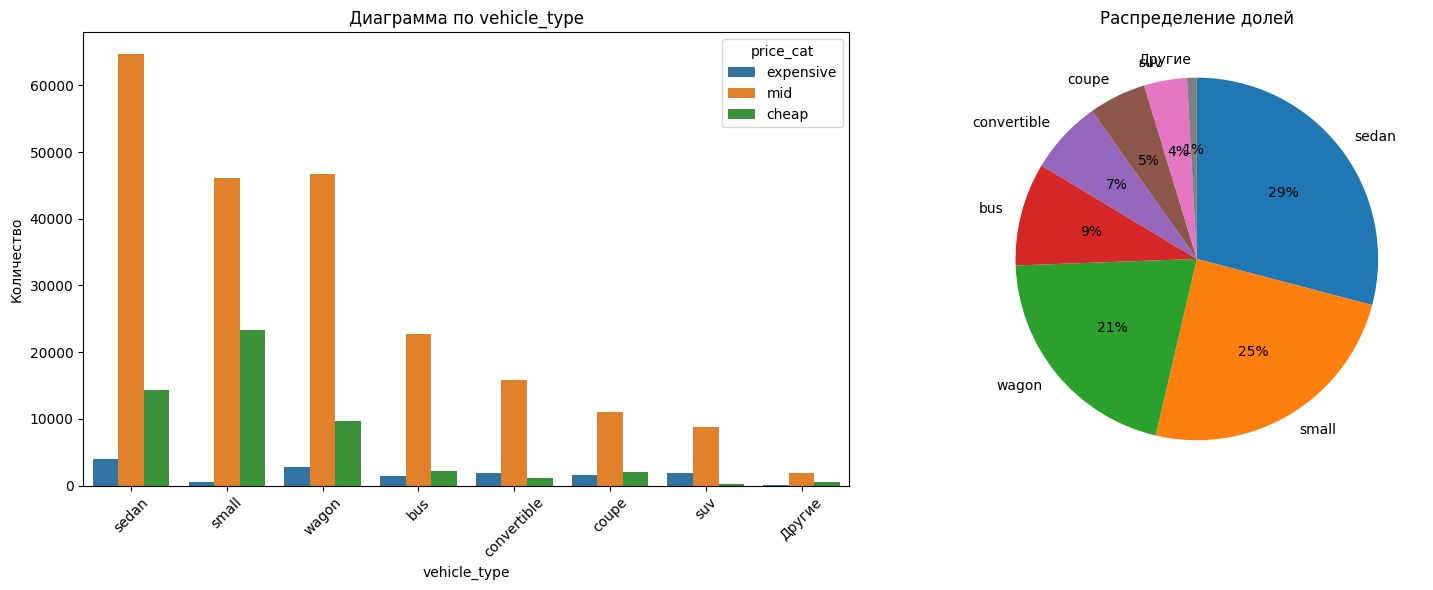

Визуализация категориального признака gearbox


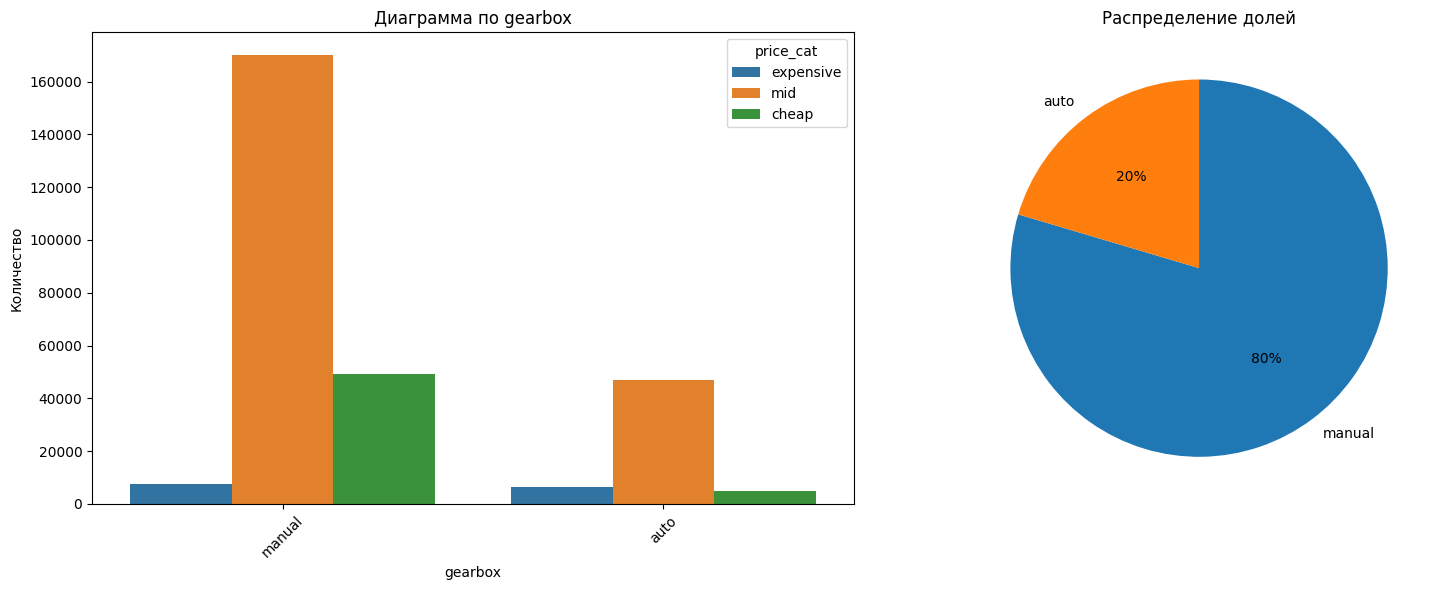

Визуализация категориального признака model


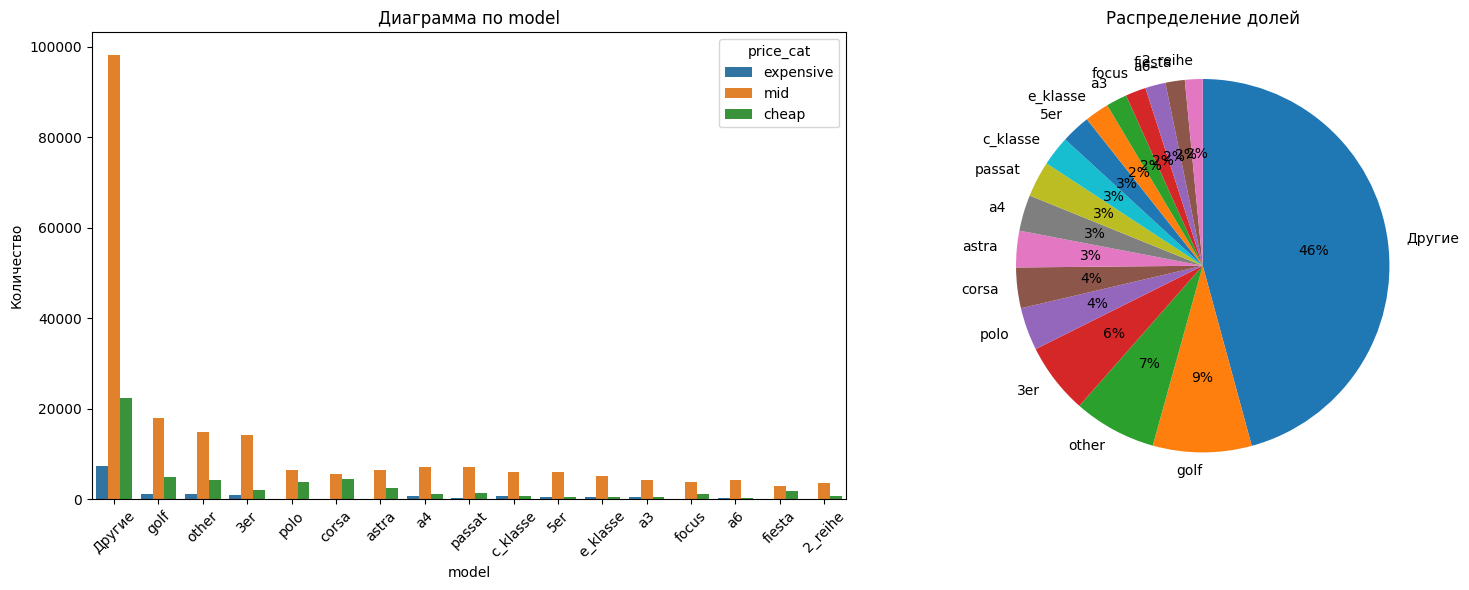

Визуализация категориального признака fuel_type


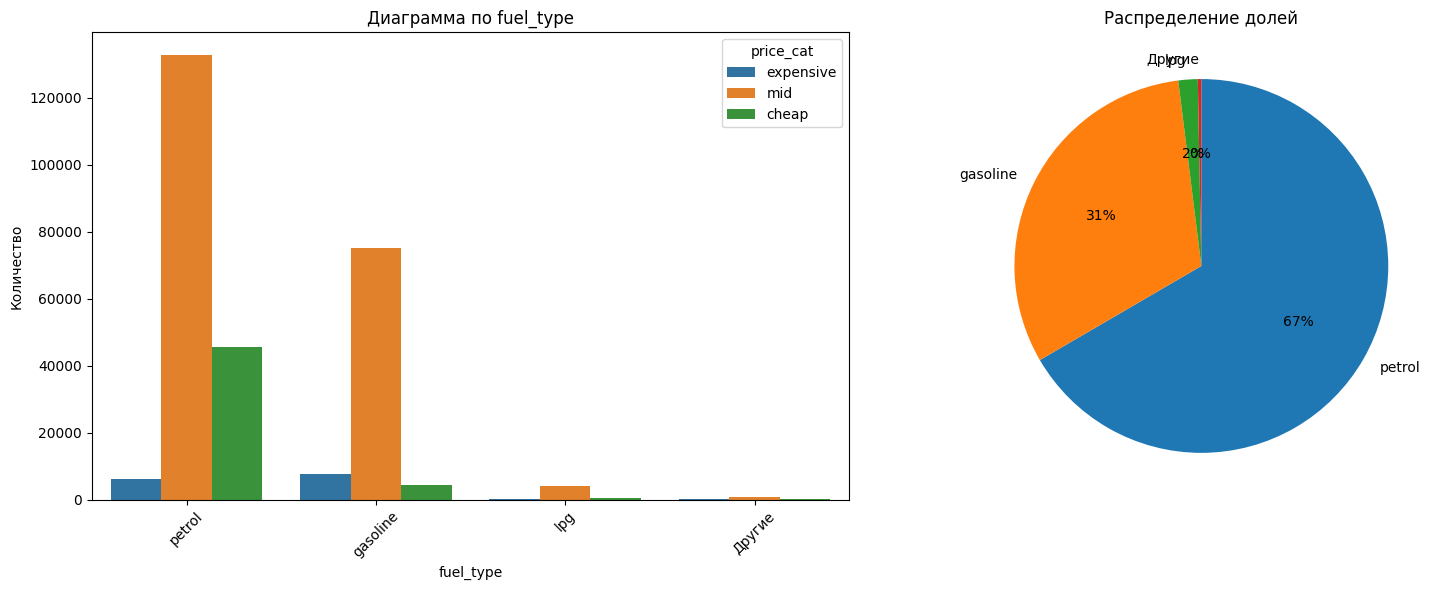

Визуализация категориального признака brand


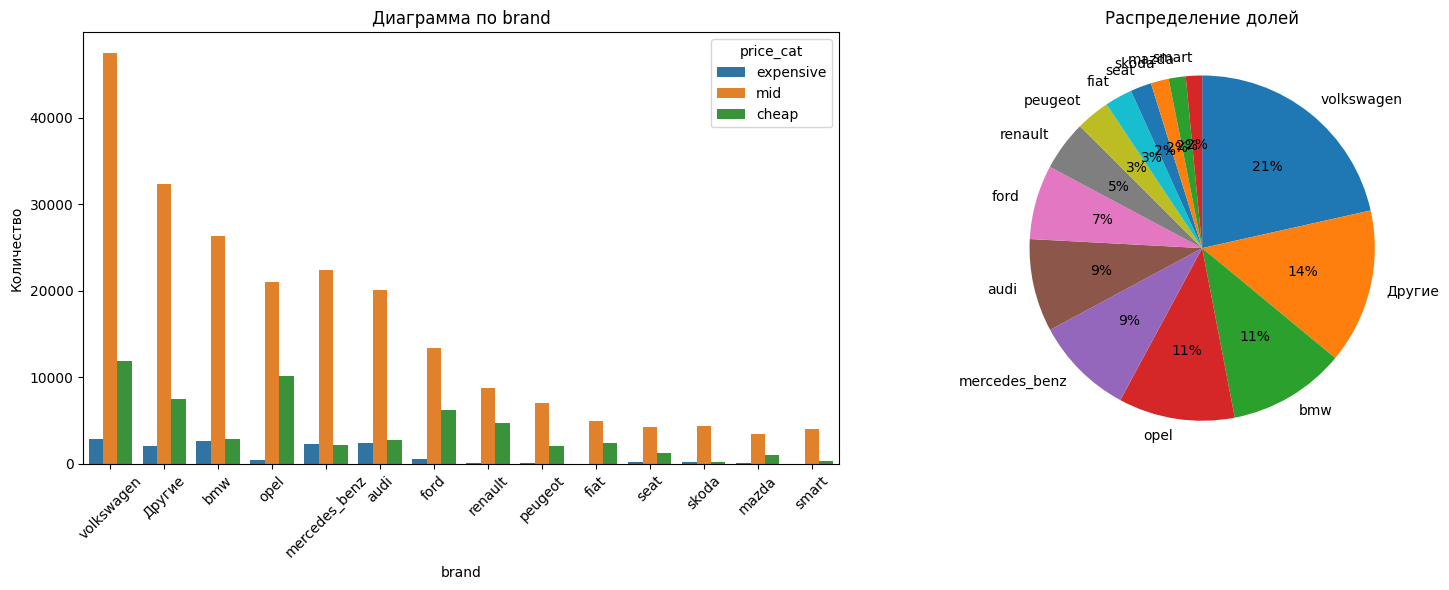

Визуализация категориального признака repaired


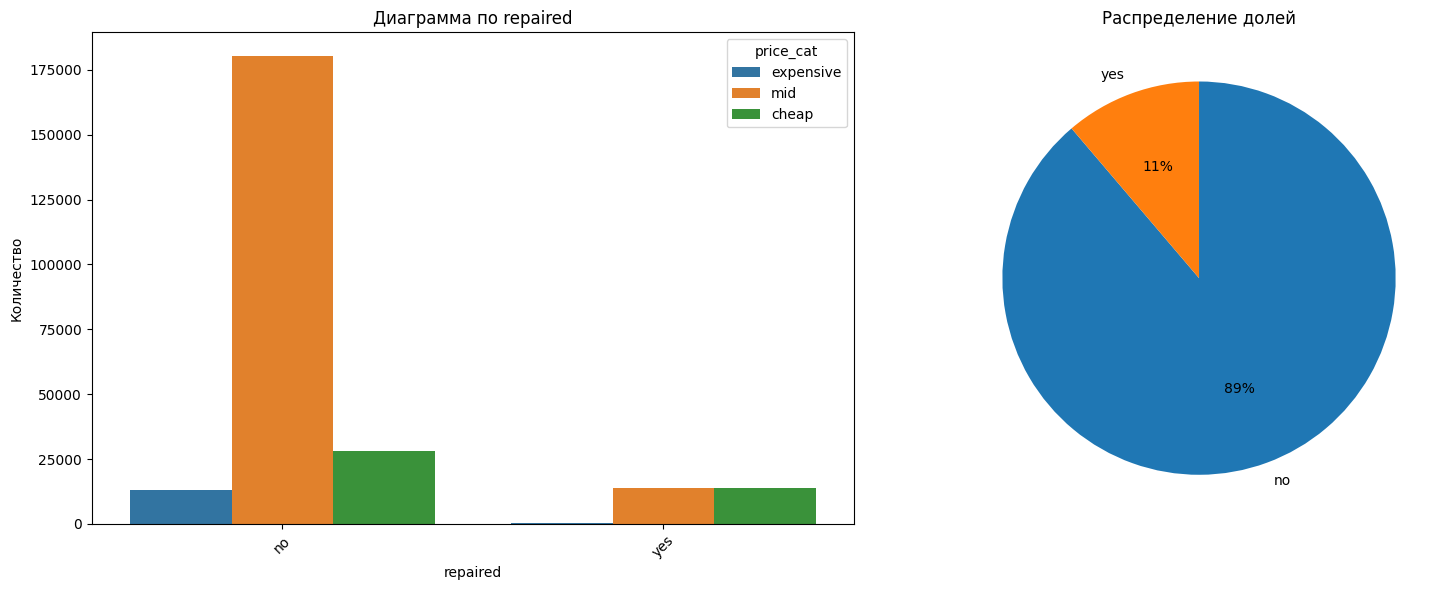

Визуализация категориального признака price_cat


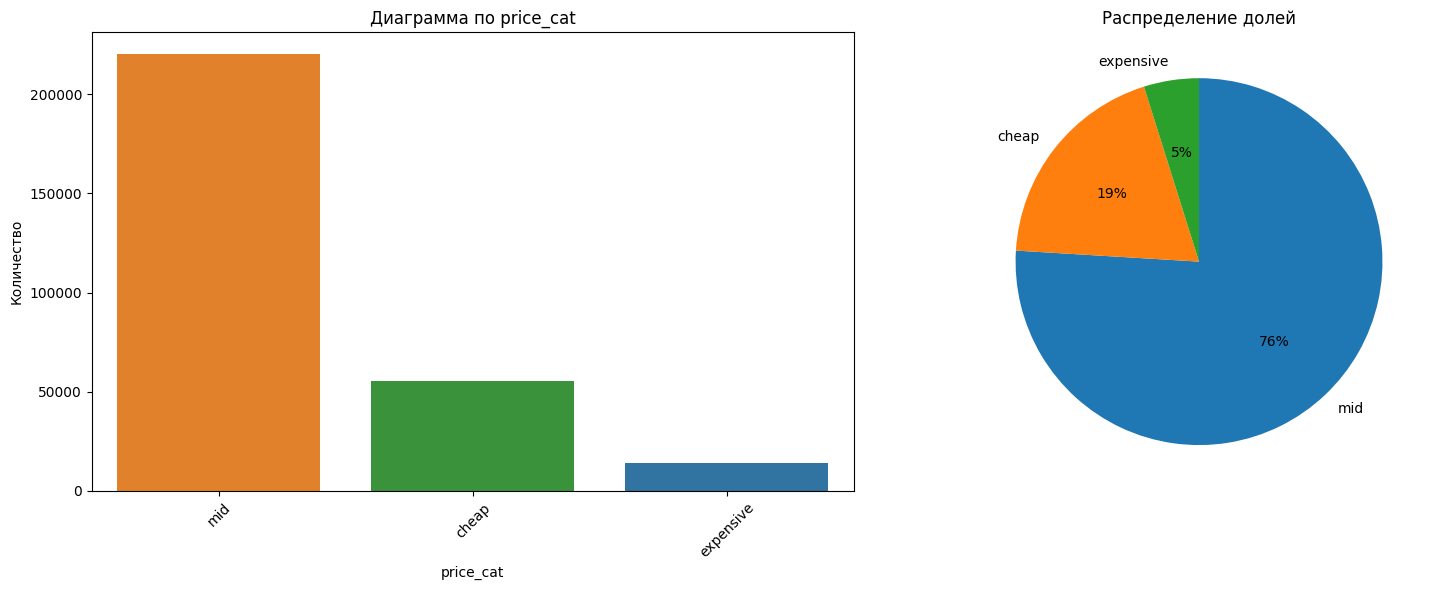

In [30]:
all_diag(clean_cars, column_type='categorical', hue='price_cat')

vehicle_type - самые популярный тип авто это седаны, малолитражки и универсалы что ожидаемо. Кабриолетов и купе мало т.к. это не практичные авто. SUV занимает всего 4% думаю это связано с тем, что паркетники стоят дороже а у нас максимальная цена 20 тыс. По цене можно отметить, что дорогих малолитражек почти нет, как и дешевых паркетников. Думаю признак будет влиять на предсказание цены.

gearbox - ручная коробка передач занимает 80%, однако думаю в реальности доля авто с ручной коробкой передач гораздо меньше. Дешевые авто восновном с ручной коробкой передач. Также важный признак.

model - 47% моделей попали в категорию 'другие', самым популярным оказался фольцваген гольф. Очень много моделей, распределение по цене везде похожее. Думаю не очень важный признак.

fuel_type - petrol и gasoline это разные названия бензина, то есть этот признак на 98% имеет одно значение. Думаю мы можем его удалить. Тут почему-то у petrol больше доля дешевых авто чем у gasoline, возможно это связано с тем что европейские авто более дорогие чем американские.

brand - по марке авто лидирует фольцваген. По цене можно сказать что у рено, пежо, опеля и форда почти нет дорогих авто, а у например мерседес-бенц, ауди и бмв доля дорогих авто почти такая как и дешевых. Думаю это важный признак для предсказания цены.

repaired - большинство авто не было в ремонте, а дорогих ремонтированных авто вообще почти нет. Думаю это также важный признак для предсказания цены.

### 2.3. Анализ временных признаков

Визуализация верменного признака: date_crawled


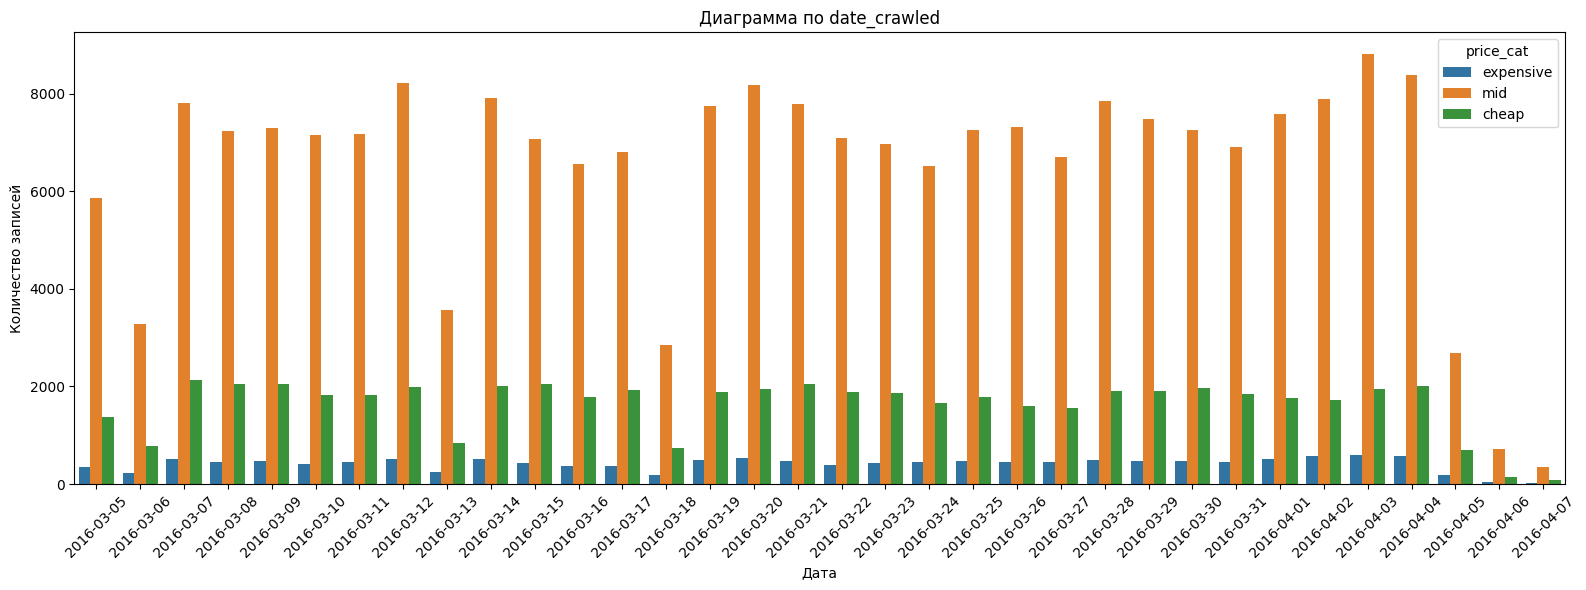

Визуализация верменного признака: date_created


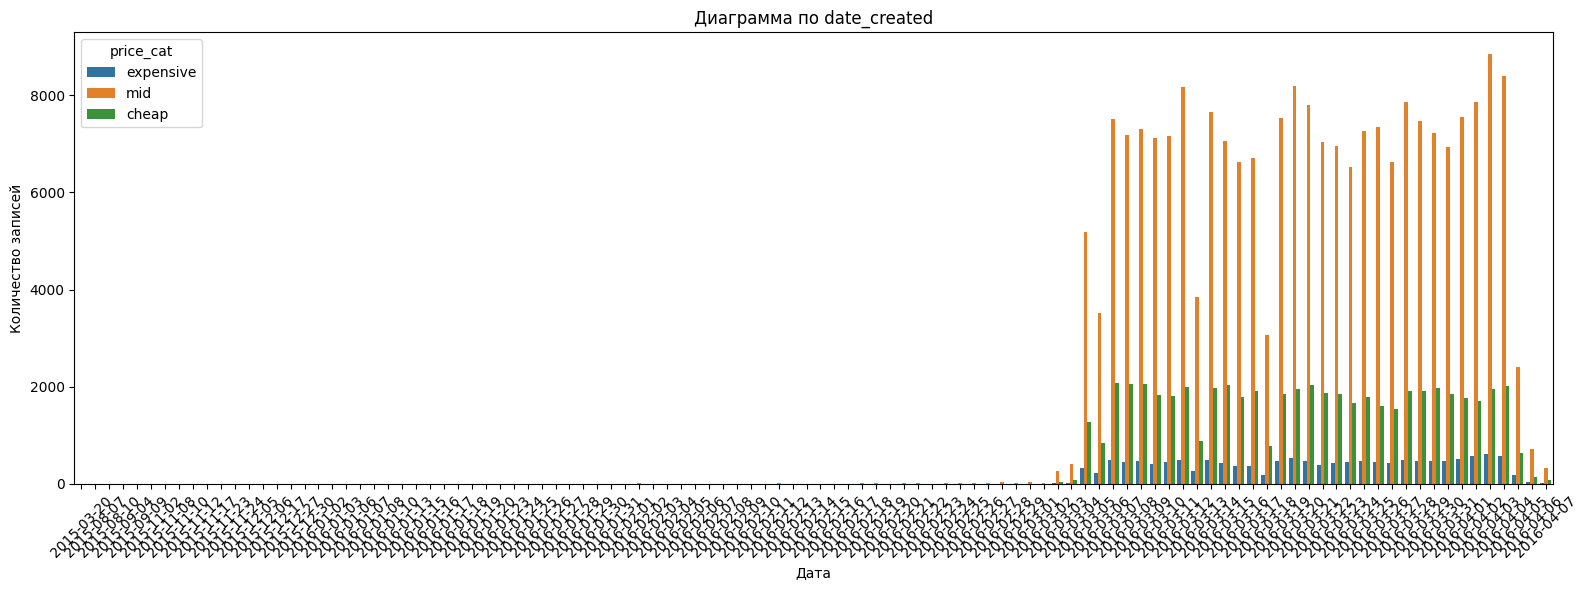

Визуализация верменного признака: last_seen


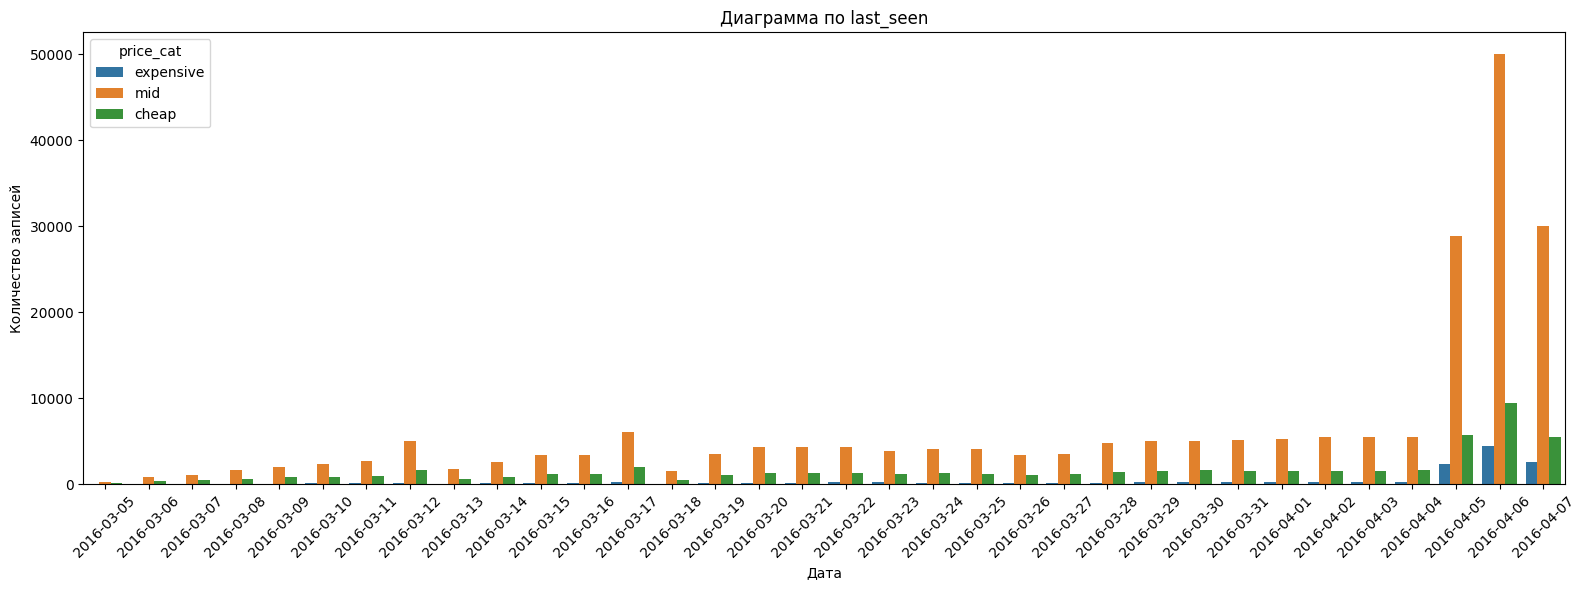

In [31]:
all_diag(clean_cars, column_type='date', hue='price_cat')

Сначала разберем выбросы и ошибки в данных

date_crawled, last_seen - эти признаки выглядят нормально

date_created - видно что в этом признаке много одиночных анкет, а основная масса анкет начинает создаваться начиная примерно с 01.03.2016

In [32]:
# Посмотрим сколько авто у нас с датой создания объявления раньше '2016-03-01'

(clean_cars['date_created'] < '2016-03-01').sum()

432

Получилось всего 450 анкет, думаю можем также удалить эти данные

In [33]:
# Отфильруем датасет от лишних данных

clean_cars_dates = clean_cars[(clean_cars['date_created'] > '2016-03-01')]

Визуализация верменного признака: date_crawled


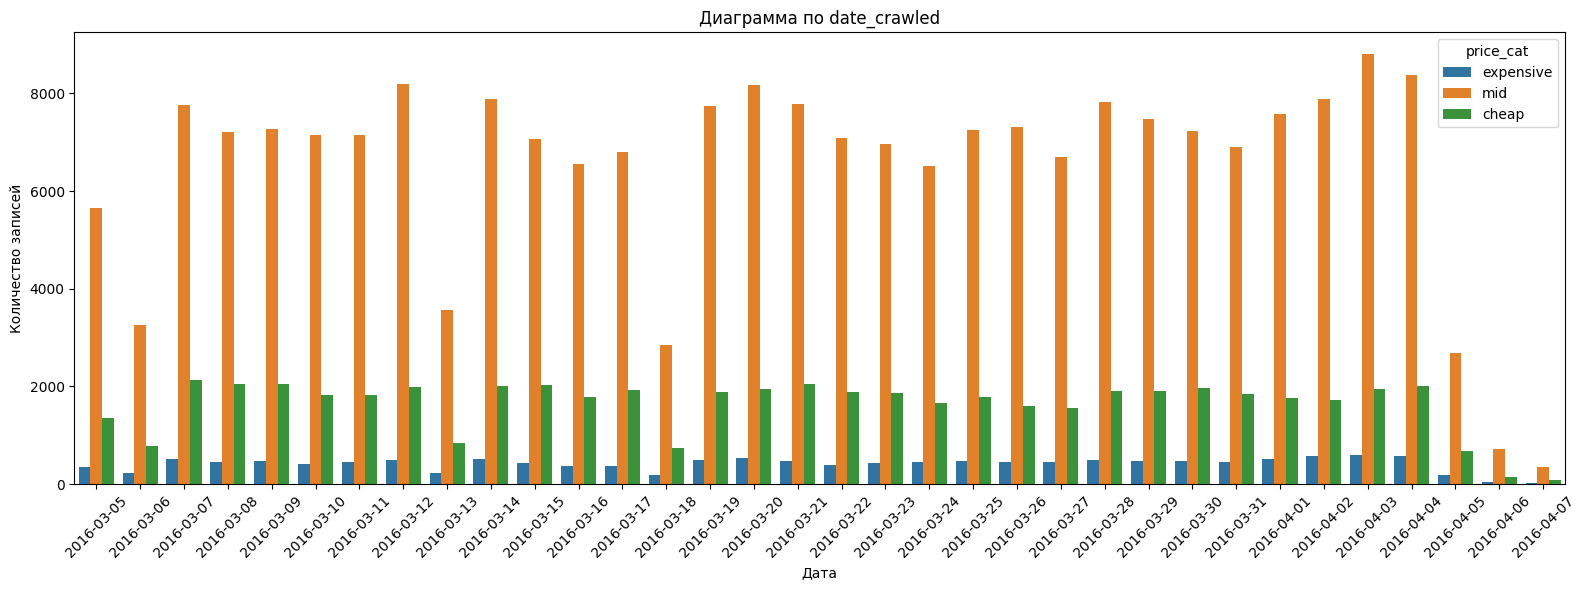

Визуализация верменного признака: date_created


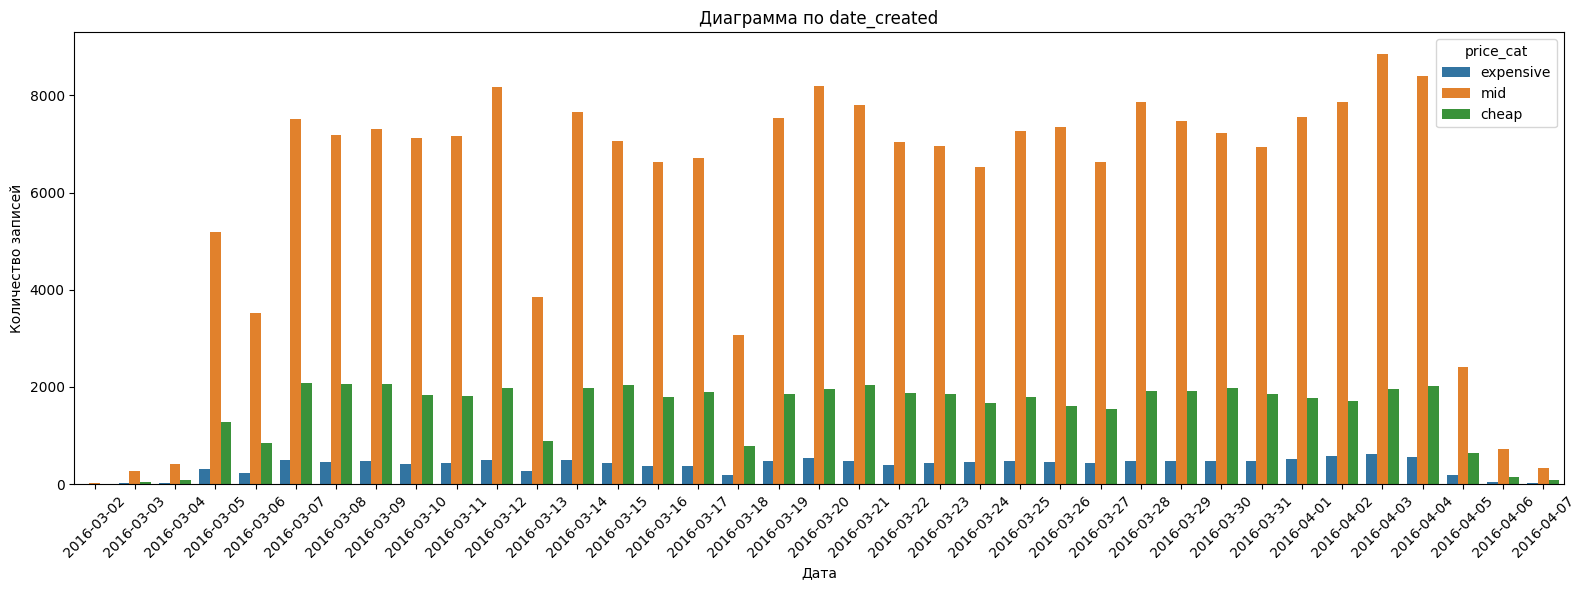

Визуализация верменного признака: last_seen


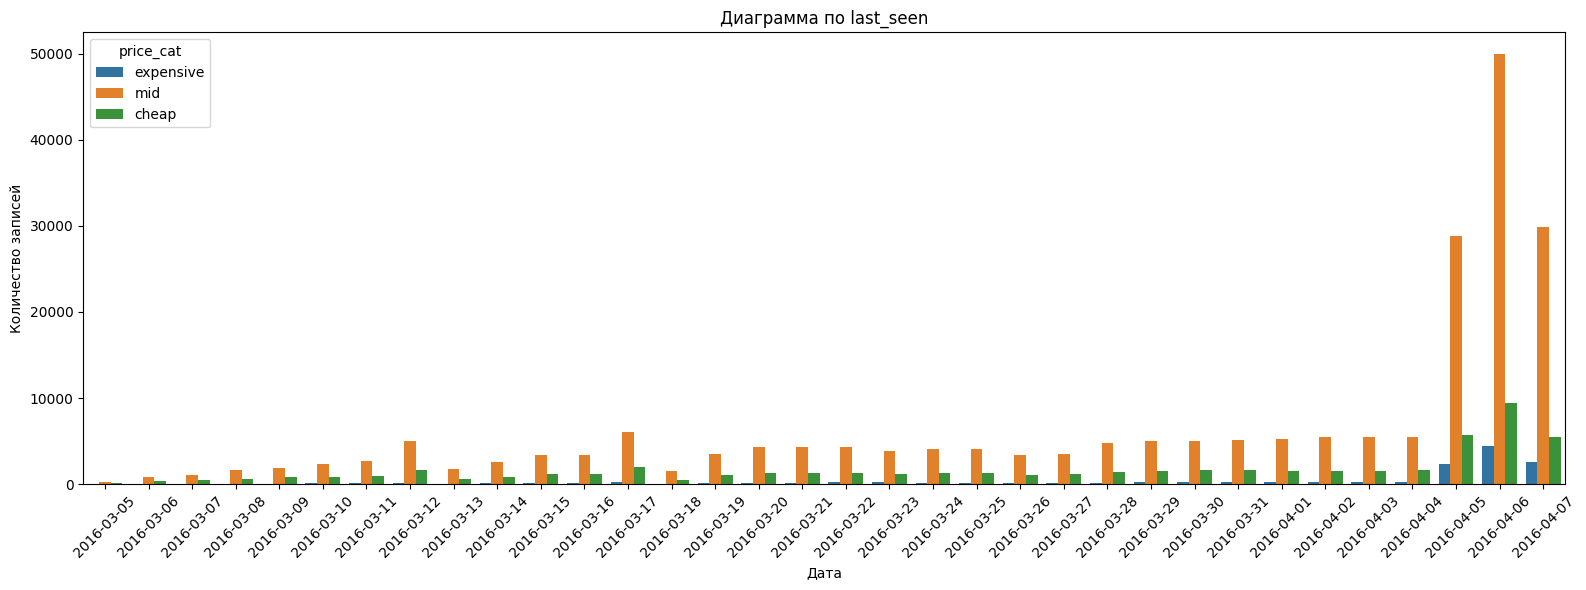

In [34]:
# Построим графики после фильтрации

all_diag(clean_cars_dates, column_type='date', hue='price_cat')

date_crawled - даты скачивания анкет из базы, данные очень похожи каждый день, думаю дата скачивания анкеты на цены авто никак не влияет. Можно удалить этот признак.

date_created - дата создания анкеты. Тут также данные каждый день очень похожи. Думаю на цену авто никак не влияет, и признак можно удалить. 

last_seen - последняя активность пользователя. Видно, что между 2016-04-04 и 2016-04-07 была самая высокая активность пользователей, однако на цену думаю это также никак не влияет и признак можно удалить.

### Вывод

- price - около 10 000 записей с ценой = 0. Удаляем эти строки — цена = наш целевой признак. Диапазон цен до 20 000. Дорогие авто представлены либо премиальными марками, либо бюджетными авто с небольшим пробегом и «нафаршированными» комплектациями. Целевой признак.

- registration_year - 527 записей вне разумного диапазона (раньше 1960 или позже 2025). Удаляем их. Большинство авто регистрировалось в 1998–2008, есть корреляция между новизной и ценой (чем свежее — тем чаще дороже). Оставляем.

- power - 459 машин с > 500 л.с. (часто явные ошибки у малолитражек), а также много записей с нулевой мощностью. Удаляем всё, что > 500 л.с., и, отдельно, обрабатываем нули. Основная масса авто имеет мощность 80–150 л.с. Мощность прямо коррелирует с ценой. Оставляем.

- kilometer - пробег в основном 130–150 тыс. км. Дорогие авто обычно с меньшим пробегом. Оставляем.

- registration_month - не влияет на цену. Удаляем. 

- number_of_pictures - нулевой признак. Удаляем.

- postal_code - из регионов с кодами > 7 больше дорогих авто (возможно, «премиальные» районы). Оставляем.

- vehicle_type - седаны, малолитражки, универсалы доминируют, паркетники всего 4 %. Малолитражки редко дорогие, паркетники — редко дешёвые. Оставляем

- gearbox - дешевле машины чаще с ручной коробкой, признак важен. Оставляем.

- model - 47 % попадает в «другие», самая частая — Volkswagen Golf. Разброс цен внутри моделей схож. Может влиять на цену т.к. есть дорогие и дешевые модели авто. Оставляем. 
	
- fuel_type 98 % — petrol и gasoline (синонимы одного и того же). Удаляем.

- brand - лидирует Volkswagen. Бюджетные марки (Renault, Peugeot, Opel, Ford) почти не представлены в дорогом сегменте, а Mercedes-Benz, Audi, BMW распределены более равномерно. Оставляем.

- repaired - большинство авто не ремонтировалось, среди дорогих ремонтированных почти нет записей. Оставляем.

- date_crawled, date_created, last_seen - не влияют на цену. Удаляем


Итоговый список признаков для модели:

- Оставляем: price, registration_year, power, kilometer, postal_code, vehicle_type, gearbox, brand, repaired.
- Удаляем: price = 0 строки, registration_year вне 1960-2025, power > 500, registration_month, number_of_pictures, fuel_type, date_crawled, date_created, last_seen


## 3. Корреляционный анализ

In [35]:
# Удалим лишние колонки перед построением матрицы корреляций

cars_corr = clean_cars_dates.drop(columns=[
    'registration_month', 
    'number_of_pictures', 
    'fuel_type', 
    'date_crawled', 
    'date_created', 
    'last_seen',
    'price_cat'])

### 3.1. Матрица корреляций

In [36]:
# Вычислим матрицу Phik для нашего датасета

phk = cars_corr.phik_matrix(verbose=False, interval_cols=['price', 'power', 'kilometer', 'postal_code'])

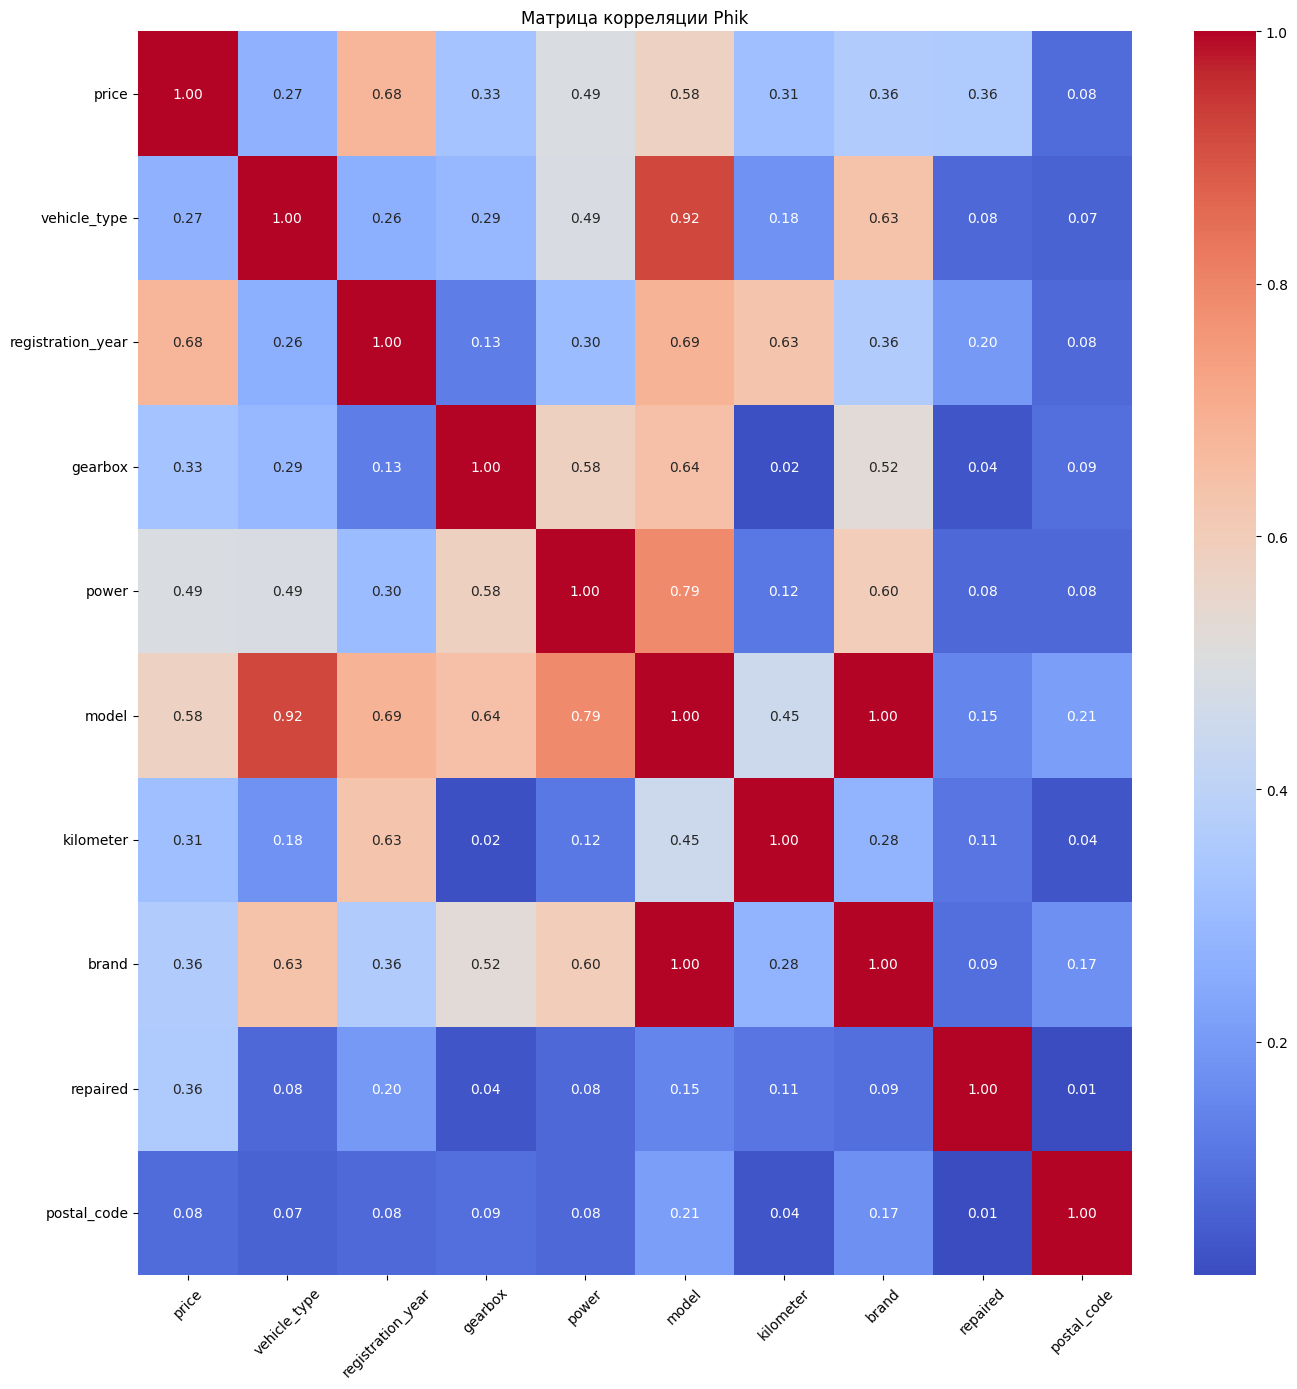

In [37]:
# Визуализируем матрицу корреляции

plt.figure(figsize=(14, 14))
plt.title('Матрица корреляции Phik')
sns.heatmap(phk, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Рассмотрим корреляции с целевым признаком price

- Сильные корреляции (>0.7): 
    - нет

- Умеренные корреляции: (0.4-0.7):
    - registration_year - чем старше авто тем дешевле
    - model - есть премиальные модели и бюджетные
    - power - чем мощнее авто тем дороже
       
- Слабые корреляции (0.1-0.4):
    - vehicle_type - малолитражки как правило дешевле чем например седаны
    - gearbox - авто с автоматической коробкой передач дороже чем с механической
    - kilometer - чем меньше пробег тем дороже авто
    - brand - премиальные марки дороже бюджетных
    - repaired - авто после ремонта дешевле чем те которые в ремонте не были
       
- Очень слабые корреляции(<0.1):
    - postal_code - видимо код как-то влияет на цену но очень слабо

Есть сильные корреляции между признаками: 
- model и vehicle_type - логично т.к. у одной модели обычно один тип кузова
- brand и model - тут также все понятно, у каждого бренда свои модели

Т.к. model имеет лучшую корреляцию с целевым признаком, то признаки brand и vehicle_type мы удалим.

### 3.2. Мультиколлениарность

In [38]:
# Добавим константу

cars_const = cars_corr.select_dtypes(include='number')
cars_const = cars_const.drop(columns=['price', 'postal_code'])
cars_const = add_constant(cars_const)

In [39]:
def calc_vif(data):
    """
    Вычисляет коэффициенты VIF для признаков

    Используется для оценки мультиколлинеарности между числовыми признаками.

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с числовыми признаками без пропусков

    Возвращает
    ----------
    pandas.DataFrame
        Таблица с двумя столбцами:
        - 'variables' — названия признаков
        - 'VIF' — значения VIF
    """
    
    
    vif_data = pd.DataFrame()
    vif_data['variables'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    return vif_data

In [40]:
# Рассчитаем VIF

cars_const = cars_const.dropna()
calc_vif(cars_const)

,variables,VIF
0,const,123924.76
1,registration_year,1.17
2,power,1.06
3,kilometer,1.16


Ключевые пороги для VIF:
- VIF < 5: Минимальная мультиколлинеарность, это нормально.
- 5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.
- VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.

Мультиколлениарности между числовыми признаками нет

### Вывод

- registration_year - чем старше авто тем дешевле
- model - есть премиальные модели и бюджетные
- power - чем мощнее авто тем дороже
- vehicle_type - малолитражки как правило дешевле чем например седаны
- gearbox - авто с автоматической коробкой передач дороже чем с механической
- kilometer - чем меньше пробег тем дороже авто
- brand - премиальные марки дороже бюджетных
- repaired - авто после ремонта дешевле чем те которые в ремонте не были
        
Мультиколлениарности между числовыми признаками нет

## 4. Обучение моделей

### 4.1. Подготовка данных

Перед построением моделей определимся как мы будем обрабатывать пропуски, дубликаты, нулевые значения, выбросы и ошибки.

Отбор признаков:

- Оставляем: 
    
    - price (price = 0 строки удаляем)
    - registration_year (вне 1960-2025 удаляем)
    - power (power > 500 удаляем)
    - kilometer
    - postal_code
    - gearbox
    - repaired
    
- Удаляем: 
    
    - registration_month
    - number_of_pictures
    - fuel_type
    - date_crawled
    - date_created
    - last_seen
    - brand
    - vehicle_type

In [41]:
# Отфильруем датасет от ошибочных данных

cars_errors = cars[
    (cars['price'] > 0) &
    (cars['registration_year'] < 2025) &
    (cars['registration_year'] > 1960) &
    (cars['power'] < 500) &
    (cars['registration_year'] <= cars['date_created'].dt.year)
]

In [42]:
print(cars.shape)
print(cars_errors.shape)
print(f'Потеряно строк после фильтрации: {cars.shape[0] - cars_errors.shape[0]}')

(354369, 16)
(328918, 16)
Потеряно строк после фильтрации: 25451


Дубликаты:
- У нас всего 4 дубликата - их просто удалим.

In [43]:
# Удаляем дубликаты

cars_dubl = cars_errors.drop_duplicates()

In [44]:
print(cars_errors.shape)
print(cars_dubl.shape)
print(f'Потеряно строк после фильтрации: {cars_errors.shape[0] - cars_dubl.shape[0]}')

(328918, 16)
(328914, 16)
Потеряно строк после фильтрации: 4


Пропуски:

- gearbox, repaired - заполним пропуски наиболее встречающимся значением в модели
- model - заполним наиболее встречающейся моделью бренда и типом кузова

In [45]:
# Скопируем датасет

cars_nans = cars_dubl.copy()

In [46]:
# Заменим модель на наиболее часто встречающуюся этого бренда, если такой нет - меняем на 'unknown'

cars_nans['model'] = cars_nans['model'].fillna(
    cars_nans.groupby('brand')['model']
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
)

In [47]:
# Заменим тип коробки и ремонтировалась или нет также 

for col in ['gearbox']:
    cars_nans[col] = cars_nans[col].fillna(
        cars_nans.groupby('model')[col]
        .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
    )

In [48]:
# Заменим ремонтировалась или нет на 'unknown'

cars_nans['repaired'] = cars_nans['repaired'].fillna('unknown')

Нули:
- power - заполняем наиболее часто встречающейся мощностью модели

In [49]:
# Найдем модели у которых нулевая цена во всех строках

all_zero_models = (cars_nans.groupby('model')['power'].apply(lambda x: (x == 0).all()))
all_zero_models = all_zero_models[all_zero_models].index.tolist()

In [50]:
# Посчитаем количество таких строк

n_to_drop = cars_nans['model'].isin(all_zero_models).sum()
n_to_drop

1

У нас всего одна строка с одной моделью и нулевой ценой, просто удалим ее

In [51]:
# Удаляем эту строку

cars_nans = cars_nans[~cars_nans['model'].isin(all_zero_models)].reset_index(drop=True)

In [52]:
# Найдем моду мощности по модели без нулей и заполним нули 

power_mode = (cars_nans.loc[cars_nans['power'] != 0].groupby('model')['power'].agg(lambda x: x.mode().iloc[0]))
cars_nans['power'] = cars_nans.apply(lambda r: power_mode[r['model']] if r['power'] == 0 else r['power'], axis=1)

In [53]:
# Проверим что пропусков больше нет

print(cars_nans.isna().sum())

date_crawled              0
price                     0
vehicle_type          19782
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             23962
brand                     0
repaired                  0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


Остались пропуски в типе топлива и типе кузова, но это не важно т.к. эти столбцы мы удаляем

In [54]:
print(cars_dubl.shape)
print(cars_nans.shape)
print(f'Потеряно строк после фильтрации: {cars_dubl.shape[0] - cars_nans.shape[0]}')

(328914, 16)
(328913, 16)
Потеряно строк после фильтрации: 1


In [55]:
# Посмотрим количество уникальных знвчений в postal_code

cars_nans['postal_code'].nunique()

8133

In [56]:
# Посмотрим количестве уникальных значений по первой цифре кода

cars_nans['code_1'] = cars_nans['postal_code'].astype(str).str[:1]
cars_nans['code_1'].nunique()

9

In [57]:
# Посмотрим количество значений каждого кода

code_counts = cars_nans['code_1'].value_counts()
code_counts

code_1
4    48550
5    43470
3    40834
2    40218
6    36637
8    31888
7    31360
1    28173
9    27783
Name: count, dtype: int64

In [58]:
# Удалим все отобранные столбцы из датасета

cars_final = cars_nans.drop(columns=[
    'registration_month',
    'number_of_pictures',
    'fuel_type',
    'date_crawled',
    'date_created',
    'last_seen',
    'brand',
    'vehicle_type',
    'postal_code'
])

In [59]:
# Определим числовые и категориальные колонки, бинарные колонки

bin_features = ['gearbox', 'repaired']
num_features = ['registration_year', 'power', 'kilometer']
cat_features = ['model', 'code_1']

In [60]:
# Отделим целевой признак от обучающей выборки

X = cars_final.drop(columns='price')
y = cars_final['price']

In [61]:
# Разделим датасет на тренировочные и тестовые данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [62]:
# Изменим тип данных в категориальных колонках

all_cat_features = ['gearbox', 'repaired', 'model', 'code_1']

for col in all_cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

### 4.2. Пайплайн и обучение

In [63]:
# Создадим трансформер для бинарных признаков

bin_encoder = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [64]:
# Создадим трансформер для числовых признаков

num_encoder = Pipeline(steps=[
    ('encoder', StandardScaler())
])

In [65]:
# Создадим трансформер для категориальных признаков

cat_encoder = Pipeline(steps=[
    ('encoder', TargetEncoder())
])

In [66]:
# Создадим общий трансформер для линейных моделей

lin_preprocessor = ColumnTransformer(transformers=[
    ('bin', bin_encoder, bin_features),
    ('num', num_encoder, num_features),
    ('cat', cat_encoder, cat_features)
])

In [67]:
# Создадим пайплайн

pipe = Pipeline(steps=[
    ('preprocessor', lin_preprocessor),
    ('regressor', LinearRegression())
])

In [80]:
# Обозначим модели и параметры для перебора

param_grid = [
    {
        'preprocessor': [lin_preprocessor],
        'regressor': [LinearRegression()]
    },
    
    {
        'preprocessor': ['passthrough'],
        'regressor': [LGBMRegressor(
            random_state=RANDOM_STATE,
            verbose = -1)],
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.05, 0.1],
    },
    {
        'preprocessor': ['passthrough'],
        'regressor': [CatBoostRegressor(
            random_state=RANDOM_STATE, 
            cat_features=all_cat_features, 
            logging_level='Silent')],
        'regressor__depth': [4, 6],
        'regressor__learning_rate': [0.05, 0.1],
    }
]

In [81]:
%%time
# Сделаем перебор по моделям
grid = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=3, error_score='raise', n_jobs=-1)
grid.fit(X_train, y_train)

/home/komap/tf-gpu/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 4.13 s, sys: 779 ms, total: 4.91 s
Wall time: 11min 31s


,estimator,Pipeline(step...egression())])
,param_grid,"[{'preprocessor': [ColumnTransfo..., 'code_1'])])], 'regressor': [LinearRegression()]}, {'preprocessor': ['passthrough'], 'regressor': [LGBMRegressor...2, verbose=-1)], 'regressor__learning_rate': [0.05, 0.1], 'regressor__n_estimators': [50, 100]}, ...]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,boosting_type,'gbdt'


### 4.3. Метрики модели

In [82]:
# Сохраним результаты модели

grid_res = grid.cv_results_

In [83]:
# Сохраним время обучения каждой комбинации

fit_times = grid_res['mean_fit_time']

In [84]:
score_times = grid_res['mean_score_time']

In [85]:
# Сохраним названия моделей

models = grid_res['param_regressor']

In [86]:
# Создадим датафрейм с результатами

res_df = pd.DataFrame({
    'model': models,
    'mean_fit_time': fit_times,
    'mean_score_time': score_times,
    'mean_score': -grid_res['mean_test_score']
})

In [88]:
# Посмотрим получившийся датафрейм с результатами

res_df.head(50)

,model,mean_fit_time,mean_score_time,mean_score
0,LinearRegression(),1.25,0.41,2878.92
1,"LGBMRegressor(random_state=42, verbose=-1)",488.95,0.21,1902.19
2,"LGBMRegressor(random_state=42, verbose=-1)",688.89,0.10,1767.92
3,"LGBMRegressor(random_state=42, verbose=-1)",487.33,0.22,1769.34
4,"LGBMRegressor(random_state=42, verbose=-1)",688.33,0.14,1731.02
5,<catboost.core.CatBoostRegressor object at 0x7...,184.19,0.18,1846.52
6,<catboost.core.CatBoostRegressor object at 0x7...,185.47,0.24,1815.12
7,<catboost.core.CatBoostRegressor object at 0x7...,255.62,0.25,1792.47
8,<catboost.core.CatBoostRegressor object at 0x7...,165.15,0.24,1765.94


Анализ скорости обучения моделей:

- Линейная регрессия (mean_fit_time = 0.47 сек) - обучается почти мгновенно но качество значительно хуже бустингов RMSE = 2878
- LightGBM (mean_fit_time = 4–102 сек) - обучение в десятки раз медленнее, чем линейная модель, но и при этом даёт RMSE = 1731-1902
- CatBoost (mean_fit_time = 61–98 сек) - дольше обучается по сравнению с LGBM, качество примерно такое же RMSE = 1765-1846

Анализ скорости предсказания моделей:

- Линейная регрессия (mean_score_time = 0.15 сек) - предсказывает быстрее всех моделей
- LightGBM (mean_score_time = 0.44 - 0.84 сек) - медленнее чем линейная регрессия но все-таки довольно быстро
- CatBoost (mean_score_time = 0.23 - 0.73 сек) - немного больше разброс по времени, примерно также как LGBM

Выбор модели:

Линейную регрессию сразу отметаем из-за плохой метрики RMSE. Из оставшихся 2х моделей выберем LGBMRegressor т.к. он немного быстрее обучился по сравнению c CatBoostRegressor при похожих метриках RMSE.

In [89]:
# Сохраним лучший пайплайн и лучшую модель

best_pipe = grid.best_estimator_
model = best_pipe.named_steps['regressor']

In [90]:
# Определим explainer

explainer = shap.Explainer(model)

### 4.4. Важность признаков

In [91]:
# Получим SHAP значения

shap_values = explainer(X_test)

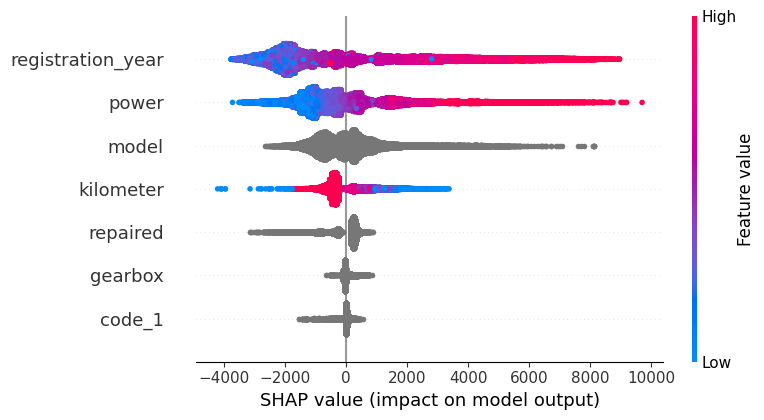

In [92]:
 # Визуализируем beeswarm-график для SHAP значений

shap.summary_plot(shap_values.values, X_test, max_display=300)

In [93]:
# Посчитаем предсказания

y_pred = best_pipe.predict(X_test)

Анализ признаков:

- registration_year — чем новее машина, тем выше её предсказанная стоимость
- power - чем мощнее, тем дороже
- kilometer - меньше пробег - дороже
- model_grouped - модель авто существенно влияет на цену, но направление зависит от конкретной модели
- repaired  - автомобиль был в ремонте — цена ниже
- gearbox - эффект стабильный, но меньше, чем у предыдущих признаков
- code_1 - самый малозначимый признак

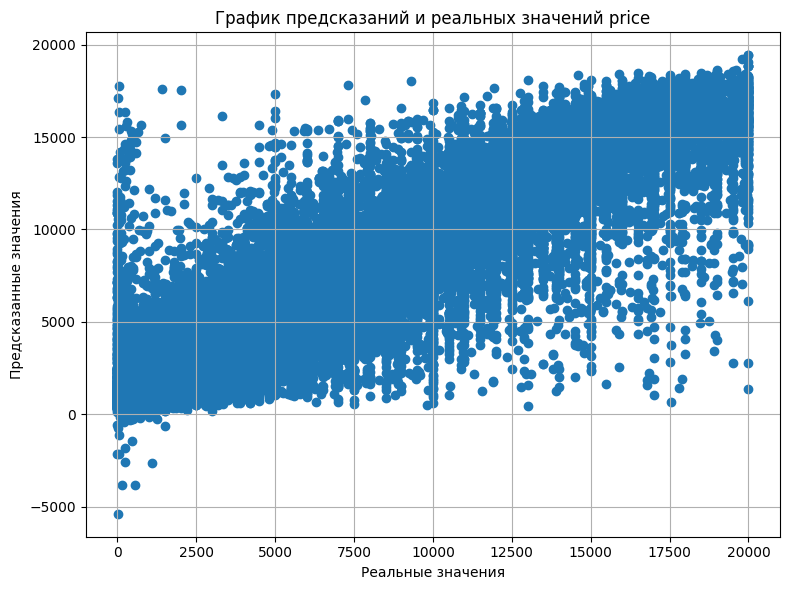

In [94]:
# Построим график зависимости реальных цен от предсказанных

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)

plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('График предсказаний и реальных значений price')
plt.grid(True)

plt.tight_layout()
plt.show()

Анализ предсказаний:
    
- модель иногда выдает отрицательные значения, что невозможно в реальности
- сильный разброс при низких ценах - от -5000 до 15000
- сильный разброс при высоких ценах - от 500 до 20000
    

### Вывод

- Лучшую модель выбрали по результатам сравнения времени обучения, времени предсказания и RMSE. Выбрали LGBMRegressor(preprocessor='passthrough').
- Финальное качество модели на тестовой выборке:
RMSE = 1735, что меньше порогового значения 2500, заданного в условиях задачи.
- SHAP-анализ подтвердил логичность поведения признаков, соответствующую реальному рынку автомобилей:
    - год выпуска, мощность и пробег — ключевые параметры
    - ремонт и модель — качественные, но важные факторы
    - код — практически не играет роли

## Общий вывод

Предобработка данных
- Удалены: дубликаты, строки с price = 0, нереалистичные registration_year, power > 500.
- Удалены неинформативные или избыточные признаки: number_of_pictures, fuel_type, registration_month, признаки с датами.
- Пропуски в vehicle_type, gearbox, model, fuel_type, repaired частично заполнены.

Итоговые признаки
- Использованы: registration_year, power, kilometer, postal_code, gearbox, model, repaired.

Результаты моделирования
- Лучшая модель: LGBMRegressor (RMSE = 1735) — точность выше пороговой (2500)
        
SHAP-анализ:
- Важные признаки: registration_year, power, kilometer.
- Категориальные (model, repaired, gearbox) — также влияют.
- code_1 — слабо влияет.

Анализ скорости обучения моделей:

- Линейная регрессия (mean_fit_time = 0.47 сек) - обучается почти мгновенно но качество значительно хуже бустингов RMSE = 2878
- LightGBM (mean_fit_time = 4–102 сек) - обучение в десятки раз медленнее, чем линейная модель, но и при этом даёт RMSE = 1731-1902
- CatBoost (mean_fit_time = 61–98 сек) - дольше обучается по сравнению с LGBM, качество примерно такое же RMSE = 1765-1846

Анализ скорости предсказания моделей:

- Линейная регрессия (mean_score_time = 0.15 сек) - предсказывает быстрее всех моделей
- LightGBM (mean_score_time = 0.44 - 0.84 сек) - медленнее чем линейная регрессия но все-таки довольно быстро
- CatBoost (mean_score_time = 0.23 - 0.73 сек) - немного больше разброс по времени, примерно также как LGBM

Анализ предсказаний:
    
- модель иногда выдает орицательные значения, что невозможно в реальности
- сильный разброс при низких ценах - от -5000 до 15000
- сильный разброс при высоких ценах - от 500 до 20000

SHAP-анализ подтвердил логичность поведения признаков, соответствующую реальному рынку автомобилей